# Libraries

In [1]:
!apt update && apt install cuda-11-8

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,375 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,692 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://ppa.launchpadcont

In [2]:
!pip uninstall tensorflow tensorflow-text tf-keras tensorstore -y
!pip install tensorflow==2.15.0

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: tensorflow-text 2.18.1
Uninstalling tensorflow-text-2.18.1:
  Successfully uninstalled tensorflow-text-2.18.1
Found existing installation: tf_keras 2.18.0
Uninstalling tf_keras-2.18.0:
  Successfully uninstalled tf_keras-2.18.0
Found existing installation: tensorstore 0.1.72
Uninstalling tensorstore-0.1.72:
  Successfully uninstalled tensorstore-0.1.72
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall

In [1]:
import tensorflow as tf
import random
import numpy as np
import numpy.random as rnd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from tqdm.notebook import tqdm
import itertools
from concurrent.futures import ProcessPoolExecutor
from google.colab import drive
drive.mount('/content/drive')
import csv
import os
from datetime import datetime
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, recall_score, precision_score
kelvin=273.15
np.random.seed(49)
tf.compat.v1.disable_v2_behavior()
font = {'family' : 'sans-serif',
        'style' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)




Mounted at /content/drive


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
tf.__version__

'2.15.0'

In [3]:
 tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Modeling

In [ ]:
'''Class for environment simulation'''

class environment():

    '''environment initializer'''

    def __init__(self, init_s):

        '''init_s: tuple of initial parameters

           self.t: temperature of air
           self.vent_degree: vent. level
           self.t_h: temperature of heater
           self.t_out: temperature outside, this values is also used as an average temperature for the calculated period
           self.c: 1 t_out is constant,0 it is modeled'''

        '''original fuction'''

        'self.t, self.vent_degree, self.t_h, self.t_w, self.t_out = init_s'

        'my version'

        self.t, self.vent_degree, self.t_h, self.t_w, self.t_out, self.c = init_s
        self.t_avg=self.t_out-4


    '''one step of environment'''

    def step(self, a):

          '''a: tuple of actions
            heat: state of heater
            vent: state of vent.'''

          heat, vent = a

          '''update of env. parameters'''

          self.t = self.t - 0.01*(self.t_w - self.t) + 0.06*(self.t_h - self.t) + 0.04*vent - 0.004*self.t*vent - 0.0005*self.t ** 2
          self.t_h = self.t_h + 0.05 * heat * (70 - self.t_h) - 0.05 * (self.t_h - self.t)
          self.t_w = self.t_w + 0.05 * (self.t - self.t_w) - 0.05 * (self.t_out - self.t)
          self.t_out = self.t_out

          '''checking of boundaries'''

          if self.t<0:
              self.t = 0
          elif self.t>35:
              self.t = 35

          self.vent_degree = self.vent_degree - (1 - vent) + 3*vent

          if self.vent_degree<0:
              self.vent_degree = 0
          elif self.vent_degree>60:
              self.vent_degree = 60

          '''returns visible parameters of environment'''

          return self.t, self.vent_degree, self.t_out
    def step2(self, a,scalled_step_n):


      '''a: tuple of actions
        heat: state of heater
        vent: state of vent.'''


      if scalled_step_n >= np.pi:
        n=math.floor(scalled_step_n/np.pi)
        scalled_step_n-=n*np.pi

      '''update of env. parameters'''

      'my version'

      t_c_fluid=np.interp(self.t_out,[293.15,318.1],[293.15,278.15])
      #self.t +=   0.032*(self.t_h - self.t) + 0.005*a[1]*(self.t_out-self.t)+ 0.025*(self.t_w - self.t) +0.016*a[2]*(t_c_fluid-self.t)
      self.t +=   0.032*(self.t_h - self.t) + 0.005*a[1]*(self.t_out-self.t)+ 0.025*(self.t_w - self.t) +0.016*a[2]*(283.15-self.t)

      t_w_fluid=np.interp(self.t_out,[253.15,318.1],[340.15,298.15])

      self.t_h += (t_w_fluid- self.t_h)*( 0.08 * a[0])-0.05*(self.t_h -self.t)


      self.t_w += 0.1 * (self.t - self.t_w) + 0.1 * (self.t_out - self.t_w)


      #self.t_w = self.t_w + 0.05 * (self.t - self.t_w) - 0.1 * (self.t_out - self.t_w)
      if self.c==1:
       self.t_out = self.t_out
      else:
        self.t_out += 0.01*np.cos(scalled_step_n-0.7)+(self.t_avg-self.t_out)*0.001+0.01*np.random.randn()

      '''checking of boundaries'''

      if self.t_h<kelvin:
            self.t_h = kelvin
      elif self.t_h>323.15:
            self.t_h = 323.15

      self.vent_degree = self.vent_degree - (1 - a[1]) + 3*a[1]

      if self.vent_degree<0:
          self.vent_degree = 0
      elif self.vent_degree>60:
          self.vent_degree = 60

      '''returns visible parameters of environment'''


      return self.t, self.vent_degree, self.t_out



    def step3(self, a,scalled_step_n, fault, multiplier=None ):

      '''a: tuple of actions
      heat: state of heater
      vent: state of vent.'''


      if scalled_step_n >= np.pi:
        n=math.floor(scalled_step_n/np.pi)
        scalled_step_n-=n*np.pi


      '''update of env. parameters'''

      'my version'



      if fault:
        self.t +=   0.032*(self.t_h - self.t) + 0.005*a[1]*(self.t_out-self.t)+ 0.025*multiplier*(self.t_w - self.t) +0.016*a[2]*(283.15-self.t)
      else:
        self.t +=   0.032*(self.t_h - self.t) + 0.005*a[1]*(self.t_out-self.t)+ 0.025*(self.t_w - self.t) +0.016*a[2]*(283.15-self.t)

      t_w_fluid=np.interp(self.t_out,[253.15,318.1],[340.15,298.15])

      self.t_h += (t_w_fluid- self.t_h)*( 0.08 * a[0])-0.05*(self.t_h -self.t)


      self.t_w += 0.1 * (self.t - self.t_w) + 0.1 * (self.t_out - self.t_w)


      #self.t_w = self.t_w + 0.05 * (self.t - self.t_w) - 0.1 * (self.t_out - self.t_w)
      if self.c==1:
       self.t_out = self.t_out
      else:
        self.t_out += 0.01*np.cos(scalled_step_n-0.7)+(self.t_avg-self.t_out)*0.001+0.005*np.random.randn()

      '''checking of boundaries'''

      if self.t_h<kelvin:
            self.t_h = kelvin
      elif self.t_h>323.15:
            self.t_h = 323.15

      self.vent_degree = self.vent_degree - (1 - a[1]) + 3*a[1]

      if self.vent_degree<0:
          self.vent_degree = 0
      elif self.vent_degree>60:
          self.vent_degree = 60

      return self.t, self.vent_degree, self.t_out

    '''sample session with random control

       num_of_steps: number of time steps
       sigma: std deviation of additive noise
       '''

    '''sample session with random control

       num_of_steps: number of time steps
       sigma: std deviation of additive noise
       '''
    def random_session(self, num_of_steps, sigma):
      '''initializing sets of env. parameters'''
      collection_a = []
      collection_t = []
      collection_noisy_t = []
      collection_t_out = []

      '''initial values of env. parameters'''
      t = self.t
      t_out = self.t_out
      noisy_t = t
      a = 3

      '''main loop'''

      for i in range(num_of_steps):
          collection_t.append(t)
          collection_noisy_t.append(noisy_t)
          collection_t_out.append(t_out)
          if 0.3 > np.random.rand():
              a = np.random.choice(4)
          collection_a.append(a)
          a_for_agent = np.unravel_index(a, (2, 2))
          t, _, t_out = self.step(a_for_agent)
          noisy_t = t + sigma*np.random.randn()

      '''returns set of t, set of t with additive gaussian noise, set of actions, set of outside temperatures'''
      return np.array(collection_t), np.array(collection_noisy_t), np.array(collection_a), np.array(collection_t_out)

    def controlled_session(self, num_of_steps, sigma,t_set,v_set,dt,dv):
      '''initializing sets of env. parameters'''
      collection_a = np.zeros((0,3), dtype=int)
      collection_t = []
      collection_noisy_t = []
      collection_t_out = []

      '''initial values of env. parameters'''
      t = self.t
      t_out = self.t_out
      noisy_t = t
      a = np.zeros((1,3), dtype=int)
      HoC=False
      '''for hvac, so a[0][0] is the heating on/off comand, a[0][1] for ventilation and a[0][2] for ac'''
      OldRange = (1440 - 0)
      NewRange = (np.pi - 0)

      '''main loop'''


      for i in range(num_of_steps):
        if i%300==0:
          if self.t_out<t_set-dt:
            HoC=True
          else:
            HoC=False
        collection_t.append(t)
        collection_noisy_t.append(noisy_t)
        collection_t_out.append(t_out)
        if noisy_t >= t_set+dt and HoC:
          a[0,0]=0
        elif noisy_t >= t_set+dt and not HoC:
          a[0,2]=1
        elif noisy_t <= t_set-dt and HoC:
          a[0,0]=1
        elif noisy_t <= t_set-dt and not HoC:
          a[0,2]=0
        if self.vent_degree> v_set+dv:
          a[0,1]=0
        elif self.vent_degree< v_set-dv:
          a[0,1]=1
        else:
          a[0,1]=a[0,1]


        collection_a=np.append(collection_a,a, axis=0)
        scaled_step = (((i - 0) * NewRange) / OldRange) + 0
        t, vent, t_out = self.step2(a[0],scaled_step)
        noisy_t = t + sigma*np.random.randn()

      '''returns set of t, set of t with additive gaussian noise, set of actions, set of outside temperatures'''

      return np.array(collection_t), np.array(collection_noisy_t), collection_a, np.array(collection_t_out)

    def DR_session(self, num_of_steps, sigma,t_set,v_set,dt,dv, DR_start, confort_boundary):
      '''initializing sets of env. parameters'''
      collection_a = np.zeros((0,3), dtype=int)
      collection_t = []
      collection_noisy_t = []
      collection_t_out = []
      collection_DR=[]
      index=0
      check= False

      '''initial values of env. parameters'''
      t = self.t
      t_out = self.t_out
      noisy_t = t
      a = np.zeros((1,3), dtype=int)

      '''for hvac, so a[0][0] is the heating on/off comand, a[0][1] for ventilation and a[0][2] for ac'''
      OldRange = (1440 - 0)
      NewRange = (np.pi - 0)
      if self.t_out<t_set-dt:
        HoC=True
        boundary=t_set-confort_boundary
      else:
        HoC=False
        boundary=t_set+confort_boundary

      '''main loop'''

      for i in range(num_of_steps):
        if i==DR_start:
          check=True

        if check==False:
          collection_DR.append(0)
          if noisy_t >= t_set+dt and HoC:
            a[0,0]=0
          elif noisy_t >= t_set+dt and not HoC:
            a[0,2]=1
          elif noisy_t <= t_set-dt and HoC:
            a[0,0]=1
          elif noisy_t <= t_set-dt and not HoC:
            a[0,2]=0
          if self.vent_degree> v_set+dv:
            a[0,1]=0
          elif self.vent_degree< v_set-dv:
            a[0,1]=1
          else:
            a[0,1]=a[0,1]
        else:
          collection_DR.append(i-DR_start+1)
          if self.vent_degree> v_set+dv:
            a[0]=[0,0,0]
          elif self.vent_degree< v_set-dv:
            a[0]=[0,1,0]
          else:
            b=a[0,1]
            a[0]=[0,0,0]
            a[0,1]=b
        collection_t.append(t)
        collection_noisy_t.append(noisy_t)
        collection_t_out.append(t_out)
        collection_a=np.append(collection_a,a, axis=0)
        scaled_step = (((i - 0) * NewRange) / OldRange) + 0
        t, vent, t_out = self.step2(a[0],scaled_step)
        noisy_t = t + sigma*np.random.randn()

        if abs(round(t,1)- round(boundary,1))<=0.25 and check== True:
          index=i
          #check= False



      '''returns set of t, set of t with additive gaussian noise, set of actions, set of outside temperatures'''

      return np.array(collection_t), np.array(collection_noisy_t), collection_a, np.array(collection_t_out), np.array(collection_DR), index,boundary


    def faulty_session(self, num_of_steps, sigma,t_set,v_set,dt,dv, fault_type,fault_start,increased_factor=None):
      """

      Args:
        num_of_steps:data generation window size, 1 step=1 minute
        sigma: std of the generated Gaussian noise
        t_set: goal temperature for the control system
        v_set:goal ventilation level for the control system
        dt: tolatence range for the goal temperature +-dt
        dv:tolatence range for the goal ventilation +-dt
        fault_type: select one of the possible faults to be modelled
                    0: at fault_start time the Heating becomes unresponsive and turns off,
                    the system will generate the regular heating response based on sensing data,
                    whitout affecting the real state of the heating.
                    1:at fault_start time the Heating becomes unresponsive and turns on,
                    the system will generate the regular heating response based on sensing data,
                    whitout affecting the real state of the heating.
                    2: at fault_start time the cooling becomes unresponsive and turns off,
                    the system will generate the regular cooling response based on sensing data,
                    whitout affecting the real state of the cooling.
                    3:at fault_start time the cooling becomes unresponsive and turns on,
                    the system will generate the regular cooling response based on sensing data,
                    whitout affecting the real state of the cooling.
                    4:at fault_start time the insolation becomes 1.5 times worse or the given increased_factor times worse (do last)
                    5:at fault_start time the sensor data becomes 1.5 times worse or the given increased_factor times worse

        fault_start: moment in time when the normal data becomes faulty data,
        set to 0 for faults that start before the generated data t0 or earlier,
        feed a random number between 150 and 300 to simulate the fault ocurring at any random time.
        increased_factor:None or float, the factor of how many times the insulation or noise level of the generated data would become worse
      """
      '''initializing history of of env. parameters'''
      collection_a = np.zeros((0,3), dtype=int)
      collection_t = []
      collection_noisy_t = []
      collection_t_out = []
      '''initializing  history of env. parameters for fault simulation'''
      collection_a_f = np.zeros((0,3), dtype=int) #for cases 0-3
      '''initial values of env. parameters'''
      t = self.t
      t_out = self.t_out
      noisy_t = t
      a = np.zeros((1,3), dtype=int)
      HoC=False
      OldRange = (1440 - 0)
      NewRange = (np.pi - 0)

      if self.t_out<t_set-dt:
        HoC=True

      else:
        HoC=False


      '''initial values of env. parameters for fault simulation'''
      a_f = np.copy(a)
      if increased_factor== None:
        multiplier=1.5
      else:
        multiplier=increased_factor
      '''main loop'''
      for i in range(num_of_steps):
        collection_t.append(t)
        collection_noisy_t.append(noisy_t)
        collection_t_out.append(t_out)
        if noisy_t >= t_set+dt and HoC:
          a[0,0]=0
        elif noisy_t >= t_set+dt and not HoC:
          a[0,2]=1
        elif noisy_t <= t_set-dt and HoC:
          a[0,0]=1
        elif noisy_t <= t_set-dt and not HoC:
          a[0,2]=0
        if self.vent_degree> v_set+dv:
          a[0,1]=0
        elif self.vent_degree< v_set-dv:
          a[0,1]=1
        else:
          a[0,1]=a[0,1]
        if fault_type==0:
          a_f = np.copy(a)
          a_f[0,0]=0
        elif fault_type==1:
          a_f = np.copy(a)
          a_f[0,0]=1
        elif fault_type==2:
          a_f = np.copy(a)
          a_f[0,2]=0
        elif fault_type==3:
          a_f = np.copy(a)
          a_f[0,2]=1
        collection_a=np.append(collection_a,a, axis=0)
        if (fault_type in [0,1,2,3] )and i>=fault_start:
          collection_a_f=np.append(collection_a_f,a_f, axis=0)
          a_for_agent = a_f[0]
        else:
          collection_a_f=np.append(collection_a_f,a, axis=0)
          a_for_agent = a[0]
        scaled_step = (((i - 0) * NewRange) / OldRange) + 0
        if fault_type==4  and i>=fault_start:
          t, _, t_out = self.step3(a_for_agent,scaled_step,multiplier=multiplier, fault= True)
        else:
          t, _, t_out = self.step3(a_for_agent,scaled_step,fault= False)
        if fault_type==5 and i>=fault_start:
          noisy_t = t + multiplier*sigma*np.random.randn()
        else:
          noisy_t = t + sigma*np.random.randn()

      '''returns set of t, set of t with additive gaussian noise, set of actions, set of outside temperatures'''

      return np.array(collection_t), np.array(collection_noisy_t), collection_a, np.array(collection_t_out),collection_a_f,HoC

def to_bin(x):
  y = (x*2**np.arange(x.shape[0]-1,-1,-1,dtype='int64')).sum()
  y = x.dot(1 << np.arange(x.size,dtype='int64')[::-1])
  return y
"""
def generate_random(init_params,number_of_pieces,session_length,std_of_noise):
    env = environment(init_params)
    '''sample session with given length and std (total length of session: number_of_pieces * session_length)'''

    s_length = number_of_pieces * session_length
    t, noisy_t, a, t_out = env.random_session(s_length, std_of_noise)

    '''reshaping dataset in appropriate for learning form'''
    t_out = t_out.reshape((number_of_pieces, session_length))
    t = t.reshape((number_of_pieces, session_length))
    noisy_t = noisy_t.reshape((number_of_pieces, session_length))
    a = a.reshape((number_of_pieces, session_length))
    return t, noisy_t, a, t_out
"""

"\ndef generate_random(init_params,number_of_pieces,session_length,std_of_noise):\n    env = environment(init_params)\n    '''sample session with given length and std (total length of session: number_of_pieces * session_length)'''\n\n    s_length = number_of_pieces * session_length\n    t, noisy_t, a, t_out = env.random_session(s_length, std_of_noise)\n\n    '''reshaping dataset in appropriate for learning form'''\n    t_out = t_out.reshape((number_of_pieces, session_length))\n    t = t.reshape((number_of_pieces, session_length))\n    noisy_t = noisy_t.reshape((number_of_pieces, session_length))\n    a = a.reshape((number_of_pieces, session_length))\n    return t, noisy_t, a, t_out\n"

# Data generation

##random data

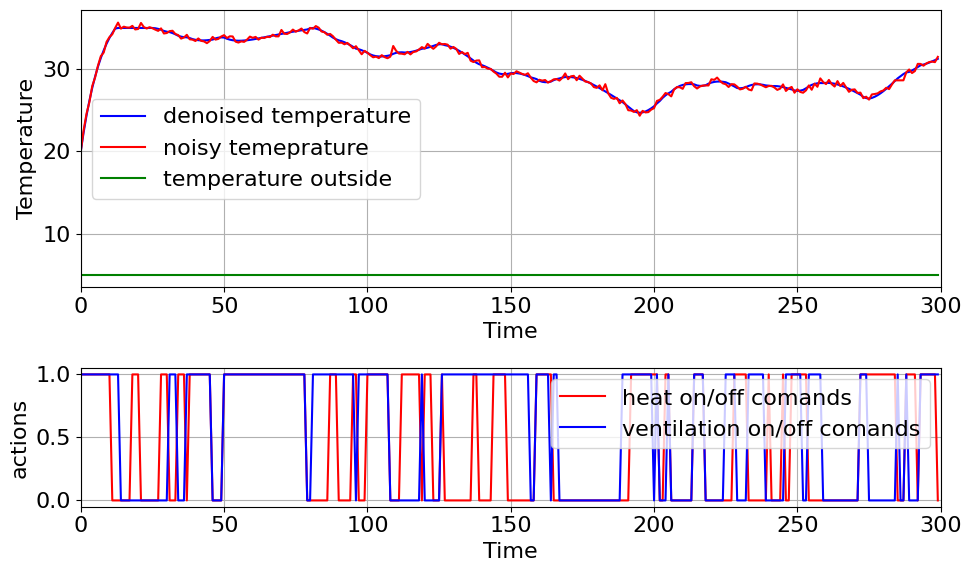

In [ ]:
init_params = (20, 20, 60, 5, 5,1) #see description of the environment class
env = environment(init_params)

'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 128
session_length = 300
std_of_noise = 0.25

s_length = number_of_pieces * session_length
t, noisy_t, a, t_out = env.random_session(s_length, std_of_noise)

'''reshaping dataset in appropriate for learning form'''
t_out = t_out.reshape((number_of_pieces, session_length))
t = t.reshape((number_of_pieces, session_length))
noisy_t = noisy_t.reshape((number_of_pieces, session_length))
a = a.reshape((number_of_pieces, session_length))
heat,vent = np.unravel_index(a, (2, 2))
'''plotting of example'''
fig, axs = plt.subplots(2, 1,gridspec_kw={'height_ratios': [2, 1]})
fig.set_figwidth(10)
fig.set_figheight(6)
axs[0].plot(t[0], 'b',label="denoised temperature")
axs[0].plot(noisy_t[0], 'r',label="noisy temeprature")
axs[0].plot(t_out[0], 'g',label="temperature outside")
axs[0].set_xlim(0, 300)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].legend()
axs[1].plot(heat[0], 'r',label="heat on/off comands")
axs[1].plot(vent[0], 'b',label="ventilation on/off comands")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('actions')
axs[1].grid(True)
axs[1].legend()
fig.tight_layout()
plt.show()


#plt.plot(t_out[0], 'g')

##Controlled data

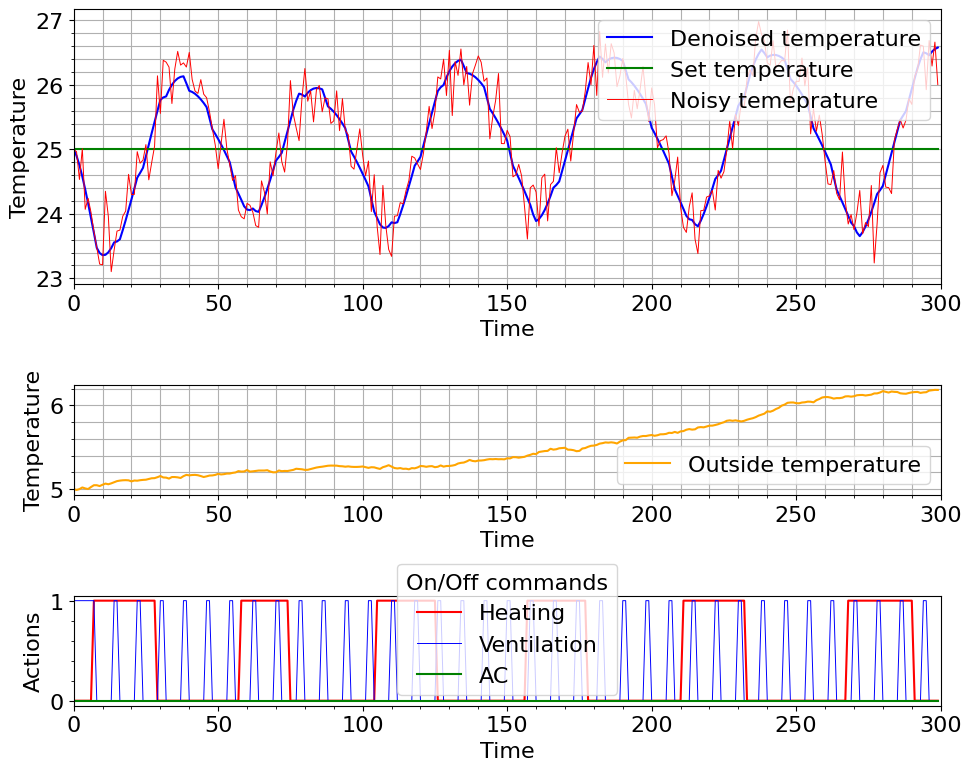

In [ ]:
'''generation of training set with target setpoints and constant t_out'''

"test for predictable behaviour"

#init_params_c = (298.15, 20, 298.15, 298.15, 298.15,1) #the room is termalised already
#init_params_c = (298.15, 20, 298.15, 298.15, 298.15,0) #the aerage temperature is the room initial temperature
#init_params_c = (298.15, 20, 298.15, 298.15, 293.15,0)# below by 5c from the set ponit
#init_params_c = (298.15, 20, 298.15, 298.15, 303.15,0)# up by 5c from the set ponit
#init_params_c = (298.15, 20, 298.15, 298.15, 240.15,1)# outside temperature low
init_params_c = (298.15, 20, 298.15, 298.15, 278.15,0)# outside temperature too low

'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 1


'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 8
session_length = 300
std_of_noise = 0.3

#init_params_c = (298.15, 20, 298.15, 298.15, 313.15,0) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
env_c = environment(init_params_c)
s_length = number_of_pieces * session_length
t_c, noisy_t_c, a_c, t_out_c = env_c.controlled_session(s_length, std_of_noise,t_set,v_set,dt,dv)

'''reshaping dataset in appropriate for learning form'''
t_out_c = t_out_c.reshape((number_of_pieces, session_length))
t_out_c=t_out_c-kelvin
t_c = t_c.reshape((number_of_pieces, session_length))
t_c=t_c-kelvin
noisy_t_c = noisy_t_c.reshape((number_of_pieces, session_length))
noisy_t_c=noisy_t_c-kelvin
a_c_dec= np.zeros((0,1), dtype=int)
for i in range(len(a_c)):
  y=to_bin(a_c[i])
  a_c_dec=np.append(a_c_dec,np.array([y]).reshape((1,1)), axis=0)
a_c_dec = a_c_dec.reshape((number_of_pieces, session_length))
heat_c =a_c[:,0].reshape((number_of_pieces, session_length))
vent_c = a_c[:,1].reshape((number_of_pieces, session_length))
ac_c=a_c[:,2].reshape((number_of_pieces, session_length))
t_set=t_set-kelvin

'''plotting of example'''
'''plotting of example'''
n0=0
fig, axs = plt.subplots(3, 1,gridspec_kw={'height_ratios': [2.5, 1,1]})
fig.set_figwidth(10)
fig.set_figheight(8)
axs[0].plot(t_c[n0], 'b',label="Denoised temperature")
#axs[0].plot(t_out_c[n0], 'orange',label="Outside temperature")
axs[0].plot(t_set*np.ones(300), 'g',label="Set temperature")
axs[0].plot(noisy_t_c[n0], 'r',label="Noisy temeprature",linewidth=.7)
axs[0].set_xlim(0, 300)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].grid(which = "minor")
axs[0].minorticks_on()
axs[0].legend(loc=1)
axs[1].plot(t_out_c[n0], 'orange',label="Outside temperature")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Temperature')
axs[1].grid(True)
axs[1].grid(which = "minor")
axs[1].minorticks_on()
axs[1].legend(loc=4)
axs[2].plot(heat_c[n0], 'r',label="Heating")
axs[2].plot(vent_c[n0], 'b',label="Ventilation",linewidth=.7)
axs[2].plot(ac_c[n0], 'g',label="AC")
axs[2].set_xlim(0, 300)
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Actions')
axs[2].grid(True)
axs[2].legend(loc=0, title='On/Off commands')
axs[2].grid(which = "major")
axs[2].minorticks_on()
fig.tight_layout()
plt.show()
test_n=6
fig.savefig('/content/drive/MyDrive/Colab Notebooks/BML figures/simulation_example'+str(test_n)+'.pdf', format='pdf')

## DR simulation

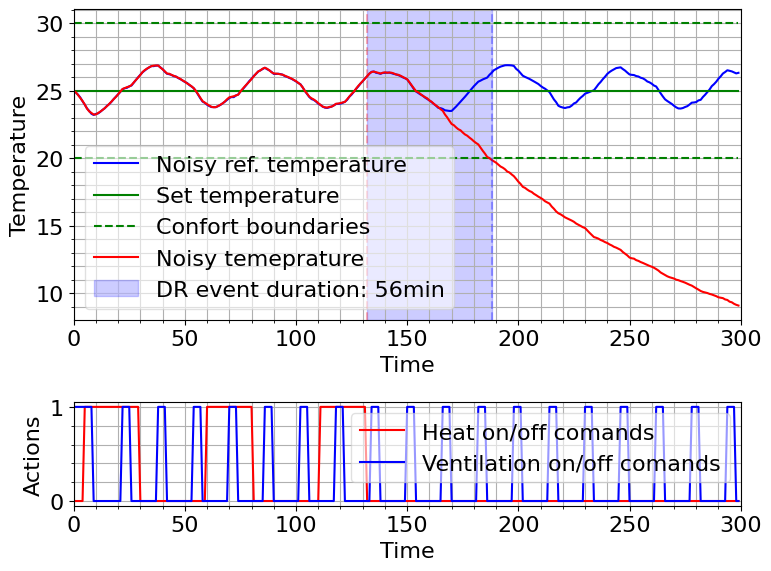

In [ ]:
'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5
DR_start=132
boundary=5
'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 1
session_length = 300
std_of_noise = 0.015

init_params_dr = (298.15, 20, 298.15, 298.15, 273.15,0) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
env_dr = environment(init_params_dr)
env_ref = environment(init_params_dr)
s_length = number_of_pieces * session_length

t_dr, noisy_t_dr, a_dr, t_out_dr,dr,index,conf_lim= env_dr.DR_session(s_length, std_of_noise,t_set,v_set,dt,dv,DR_start,boundary)
t_ref,noisy_t_ref,_,_=env_ref.controlled_session(s_length, std_of_noise,t_set,v_set,dt,dv)

'''reshaping dataset in appropriate for learning form'''
t_out_dr = t_out_dr.reshape((number_of_pieces, session_length))
t_out_dr=t_out_dr-kelvin
t_dr = t_dr.reshape((number_of_pieces, session_length))
t_dr=t_dr-kelvin
noisy_t_dr = noisy_t_dr.reshape((number_of_pieces, session_length))
noisy_t_dr=noisy_t_dr-kelvin
a_dr_dec= np.zeros((0,1), dtype=int)
for i in range(len(a_dr)):
  y=to_bin(a_dr[i])
  a_dr_dec=np.append(a_dr_dec,np.array([y]).reshape((1,1)), axis=0)
a_dr_dec = a_dr_dec.reshape((number_of_pieces, session_length))
heat_dr =a_dr[:,0].reshape((number_of_pieces, session_length))
vent_dr = a_dr[:,1].reshape((number_of_pieces, session_length))
ac_dr=a_dr[:,2].reshape((number_of_pieces, session_length))
t_set=t_set-kelvin

noisy_t_ref = noisy_t_ref.reshape((number_of_pieces, session_length))
noisy_t_ref=noisy_t_ref-kelvin
conf_lim= conf_lim- kelvin
'''plotting of example'''
'''plotting of example'''
fig, axs = plt.subplots(2, 1,gridspec_kw={'height_ratios': [3, 1]})
fig.set_figwidth(8)
fig.set_figheight(6)
#axs[0].plot(t_dr[0], 'y',label="denoised DR temperature")
axs[0].plot(noisy_t_ref[0], 'b',label="Noisy ref. temperature")
#axs[0].plot(t_out_dr[0], 'orange',label="outside temperature")
axs[0].plot(t_set*np.ones(300), 'g',label="Set temperature")
axs[0].plot((t_set-boundary)*np.ones(300), 'g',label="Confort boundaries",linestyle='dashed')
axs[0].plot((t_set+boundary)*np.ones(300), 'g',linestyle='dashed')
axs[0].plot(noisy_t_dr[0], 'r',label="Noisy temeprature")
axs[0].axvspan(DR_start,index,color = 'b', label = 'DR event duration: '+str(index-DR_start)+'min',alpha=0.2)
axs[0].axvline(x = DR_start, color = 'r',linestyle='dashed',alpha=0.3)
axs[0].axvline(x = index, color = 'b',linestyle='dashed',alpha=0.3)
axs[0].set_xlim(0, 300)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].grid(which = "minor")
axs[0].minorticks_on()
axs[0].legend(framealpha=0.6,loc= 'lower left')
axs[1].plot(heat_dr[0], 'r',label="Heat on/off comands")
axs[1].plot(vent_dr[0], 'b',label="Ventilation on/off comands")
#axs[1].plot(ac_dr[0], 'g',label="ac on/off comands")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Actions')
axs[1].grid(True)
axs[1].legend(framealpha=0.6)
axs[1].grid(which = "minor")
axs[1].minorticks_on()
fig.tight_layout()
plt.show()


In [ ]:

fig.savefig('/content/drive/MyDrive/Colab Notebooks/BML figures/DR_planning_ max_duration.pdf', format='pdf')

## Fault data

1


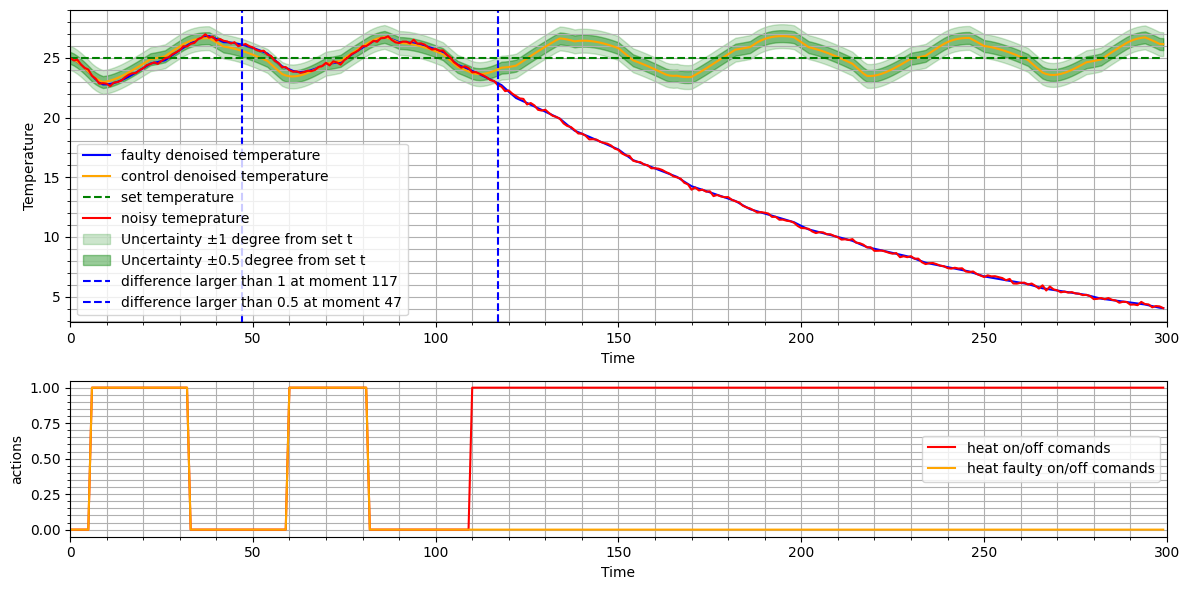

In [ ]:
"""fault_type: select one of the possible faults to be modelled
                     0: at fault_start time the Heating becomes unresponsive and turns off,
                    the system will generate the regular heating response based on sensing data,
                    whitout affecting the real state of the heating.
                    1:at fault_start time the Heating becomes unresponsive and turns on,
                    the system will generate the regular heating response based on sensing data,
                    whitout affecting the real state of the heating.
                    2: at fault_start time the cooling becomes unresponsive and turns off,
                    the system will generate the regular cooling response based on sensing data,
                    whitout affecting the real state of the cooling.
                    3:at fault_start time the cooling becomes unresponsive and turns on,
                    the system will generate the regular cooling response based on sensing data,
                    whitout affecting the real state of the cooling.
                    4:at fault_start time the insolation becomes 1.5 times worse or the given increased_factor times worse (do last)
                    5:at fault_start time the sensor data becomes 1.5 times worse or the given increased_factor times worse

         fault_start: moment in time when the normal data becomes faulty data,
          set to 0 for faults that start before the generated data t0 or earlier,
          feed a random number between 150 and 300 to simulate the fault ocurring at any random time.
          increased_factor:None or float, the factor of how many times the insulation or noise level of the generated data would become worse
"""

'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5


'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 1
session_length = 300
std_of_noise = 0.1

init_params_f = (298.15, 20, 298.15, 298.15, 273.15,0) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
env_f = environment(init_params_f)
s_length = number_of_pieces * session_length
t_f, noisy_t_f, a_f, t_out_f,a_fault,_= env_f.faulty_session(s_length, std_of_noise,t_set,v_set,dt,dv, fault_type=0, fault_start=100,increased_factor=2.5)
env_c = environment(init_params_f)
t_c, noisy_t_c, a_c, t_out_c = env_c.controlled_session(s_length, std_of_noise,t_set,v_set,dt,dv)
'''reshaping dataset in appropriate for learning form'''
t_out_f = t_out_f.reshape((number_of_pieces, session_length))
t_out_f=t_out_f-kelvin
t_f = t_f.reshape((number_of_pieces, session_length))
t_f=t_f-kelvin
t_c = t_c.reshape((number_of_pieces, session_length))
t_c=t_c-kelvin
noisy_t_f = noisy_t_f.reshape((number_of_pieces, session_length))
noisy_t_f=noisy_t_f-kelvin
t_set=t_set-kelvin


a_f_dec= np.zeros((0,1), dtype=int)
for i in range(len(a_f)):
  y=to_bin(a_f[i])
  a_f_dec=np.append(a_f_dec,np.array([y]).reshape((1,1)), axis=0)
a_f_dec = a_f_dec.reshape((number_of_pieces, session_length))
heat_f =a_f[:,0].reshape((number_of_pieces, session_length))
vent_f = a_f[:,1].reshape((number_of_pieces, session_length))
ac_f=a_f[:,2].reshape((number_of_pieces, session_length))


a_fault_dec= np.zeros((0,1), dtype=int)
for i in range(len(a_fault)):
  y=to_bin(a_fault[i])
  a_fault_dec=np.append(a_fault_dec,np.array([y]).reshape((1,1)), axis=0)
a_fault_dec = a_fault_dec.reshape((number_of_pieces, session_length))
heat_fault =a_fault[:,0].reshape((number_of_pieces, session_length))
vent_fault = a_fault[:,1].reshape((number_of_pieces, session_length))
ac_fault=a_fault[:,2].reshape((number_of_pieces, session_length))


'''plotting of example'''
'''plotting of example'''
fig, axs = plt.subplots(2, 1,gridspec_kw={'height_ratios': [2, 1]})
fig.set_figwidth(12)
fig.set_figheight(6)
axs[0].plot(t_f[0], 'b',label="faulty denoised temperature")
axs[0].plot(t_c[0], 'orange',label="control denoised temperature")
#axs[0].plot(t_out_f[0], 'black',label="outside temperature")
axs[0].plot(t_set*np.ones(300), 'g',label="set temperature",linestyle='dashed')
axs[0].plot(noisy_t_f[0], 'r',label="noisy temeprature")
axs[0].fill_between(range(300), t_c[0] - 1, t_c[0] + 1, color='green', alpha=0.2, label='Uncertainty ±1 degree from set t')
axs[0].fill_between(range(300), t_c[0] - 0.5, t_c[0] + 0.5, color='green', alpha=0.4, label='Uncertainty ±0.5 degree from set t')

limit_1 = None
limit_2 = None
outside_1 = (t_f[0] < t_c[0] - 1) | (t_f[0] > t_c[0] + 1)
outside_2 = (t_f[0] < t_c[0] - 0.5) | (t_f[0] > t_c[0] + 0.5)
for i in range(300):
    if outside_1[i] and limit_1 is None:
        limit_1 = i
if limit_1 is not None:
    axs[0].axvline(x = limit_1, color = 'b', label = 'difference larger than 1 at moment '+str(limit_1),linestyle='dashed')
for i in range(300):
    if outside_2[i] and limit_2 is None:
        limit_2 = i
if limit_2 is not None:
    axs[0].axvline(x = limit_2, color = 'b', label = 'difference larger than 0.5 at moment '+str(limit_2),linestyle='dashed')
axs[0].set_xlim(0, 300)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].grid(which = "minor")
axs[0].minorticks_on()
axs[0].legend()
axs[1].plot(heat_f[0], 'r',label="heat on/off comands")
#axs[1].plot(vent_f[0], 'b',label="ventilation on/off comands")
axs[1].plot(heat_fault[0], 'orange',label="heat faulty on/off comands")
#axs[1].plot(vent_fault[0], 'green',label="ventilation faulty on/off comands")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('actions')
axs[1].grid(True)
axs[1].legend()
axs[1].grid(which = "minor")
axs[1].minorticks_on()
fig.tight_layout()
plt.show()


In [ ]:
_

True

## training bach data generation

In [ ]:
#create data set with 25c as the target temperature and 40 as the ventilation setpoint, and different verage outside temperatures
'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5


'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 2
session_length = 300
s_length = number_of_pieces * session_length

std_of_noise =np.round(np.linspace(0.01,0.5,5),decimals=2)
t_start=np.round(np.linspace(293.15,303.15,5),decimals=2)
v_start= np.round(np.linspace(20,60,4),decimals=2)
t_h_start= np.round(np.linspace(293.15,340.15,5),decimals=2)
t_w_start= np.round(np.linspace(273.15,308.15,10),decimals=2)
t_out_start= np.round(np.linspace(253.15,295.15,15),decimals=2)
init_params_c = list(itertools.product(t_start, v_start, t_h_start, t_w_start, t_out_start,[0])) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
#init_params_c_tset = list(itertools.product(t_start, v_start, t_h_start, t_w_start, [t_set],[0])) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
#inint_test=init_params_c+init_params_c_tset+init_params_c_tset+init_params_c_tset+init_params_c_tset
init_params_c_sh= random.sample(init_params_c, len(init_params_c))
np.random.shuffle(std_of_noise)

In [ ]:
len(init_params_c_sh)

15000

In [ ]:
t_out_c = np.empty([number_of_pieces, session_length])
t_c=np.empty([number_of_pieces, session_length])
noisy_t_c=np.empty([number_of_pieces, session_length])
a_c=np.empty([number_of_pieces, session_length])




for i in tqdm(range(0,500)):
  env_c = environment(init_params_c_sh[i])
  for j in range(len(std_of_noise)):
    t_ci, noisy_t_ci, a_ci, t_out_ci = env_c.controlled_session(s_length, std_of_noise[j],t_set,v_set,dt,dv)

    '''reshaping dataset in appropriate for learning form'''
    t_out_ci = t_out_ci.reshape((number_of_pieces, session_length))
    t_out_ci=t_out_ci[1]-kelvin
    t_ci = t_ci.reshape((number_of_pieces, session_length))
    t_ci=t_ci[1]-kelvin
    noisy_t_ci = noisy_t_ci.reshape((number_of_pieces, session_length))
    noisy_t_ci=noisy_t_ci[1]-kelvin
    a_c_dec= np.zeros((0,1), dtype=int)
    for i in range(len(a_ci)):
      y=to_bin(a_ci[i])
      a_c_dec=np.append(a_c_dec,np.array([y]).reshape(1,1), axis=0)
    a_c_dec = a_c_dec.reshape((number_of_pieces, session_length))
    a_c_dec = a_c_dec[1]
    #heat_c,vent_c = np.unravel_index(a_c, (2, 2))


    #concatenate

    t_out_c=np.vstack((t_out_c,t_out_ci))
    t_c=np.vstack((t_c,t_ci))
    noisy_t_c=np.vstack((noisy_t_c,noisy_t_ci))
    a_c=np.vstack((a_c,a_c_dec))
t_out_c=t_out_c[number_of_pieces:,:]
t_c=t_c[number_of_pieces:,:]
noisy_t_c=noisy_t_c[number_of_pieces:,:]
a_c=a_c[number_of_pieces:,:]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
np.savez_compressed('/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_heatingonly.npz', t_out_c=t_out_c, t_c=t_c,noisy_t_c=noisy_t_c,a_c=a_c)

## tests batch dataset


In [ ]:
#create data set with 25c as the target temperature and 40 as the ventilation setpoint, and different verage outside temperatures
'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5


'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 2
session_length = 300
s_length = number_of_pieces * session_length

std_of_noise =[0.8]
t_start=np.round(np.linspace(293.15,303.15,8),decimals=2)
v_start= np.round(np.linspace(20,60,10),decimals=2)
t_h_start= np.round(np.linspace(293.15,340.15,8),decimals=2)
t_w_start= np.round(np.linspace(273.15,308.15,14),decimals=2)
t_out_start= np.round(np.linspace(253.15,290.15,8),decimals=2)
init_params_c = list(itertools.product(t_start, v_start, t_h_start, t_w_start, t_out_start,[0])) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
init_params_c_tset = list(itertools.product(t_start, v_start, t_h_start, t_w_start, [t_set],[0])) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
#inint_test=init_params_c+init_params_c_tset+init_params_c_tset+init_params_c_tset+init_params_c_tset
init_params_c_sh= random.sample(init_params_c, len(init_params_c))
#np.random.shuffle(std_of_noise)

In [ ]:
std_of_noise

[0.8]

In [ ]:
t_out_c = np.empty([number_of_pieces, session_length])
t_c=np.empty([number_of_pieces, session_length])
noisy_t_c=np.empty([number_of_pieces, session_length])
a_c=np.empty([number_of_pieces, session_length])




for i in tqdm(range(0,500)):
  env_c = environment(init_params_c_sh[i])
  for j in range(len(std_of_noise)):
    t_ci, noisy_t_ci, a_ci, t_out_ci = env_c.controlled_session(s_length, std_of_noise[j],t_set,v_set,dt,dv)

    '''reshaping dataset in appropriate for learning form'''
    t_out_ci = t_out_ci.reshape((number_of_pieces, session_length))
    t_out_ci=t_out_ci[1]-kelvin
    t_ci = t_ci.reshape((number_of_pieces, session_length))
    t_ci=t_ci[1]-kelvin
    noisy_t_ci = noisy_t_ci.reshape((number_of_pieces, session_length))
    noisy_t_ci=noisy_t_ci[1]-kelvin
    a_c_dec= np.zeros((0,1), dtype=int)
    for i in range(len(a_ci)):
      y=to_bin(a_ci[i])
      a_c_dec=np.append(a_c_dec,np.array([y]).reshape(1,1), axis=0)
    a_c_dec = a_c_dec.reshape((number_of_pieces, session_length))
    a_c_dec = a_c_dec[1]
    #heat_c,vent_c = np.unravel_index(a_c, (2, 2))


    #concatenate

    t_out_c=np.vstack((t_out_c,t_out_ci))
    t_c=np.vstack((t_c,t_ci))
    noisy_t_c=np.vstack((noisy_t_c,noisy_t_ci))
    a_c=np.vstack((a_c,a_c_dec))
t_out_c=t_out_c[number_of_pieces:,:]
t_c=t_c[number_of_pieces:,:]
noisy_t_c=noisy_t_c[number_of_pieces:,:]
a_c=a_c[number_of_pieces:,:]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
np.savez_compressed('/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_noise_effect_test.npz', t_out_c=t_out_c[number_of_pieces:], t_c=t_c[number_of_pieces:],noisy_t_c=noisy_t_c[number_of_pieces:],a_c=a_c[number_of_pieces:])

## DR test batch dataset

In [ ]:
#create data set with 25c as the target temperature and 40 as the ventilation setpoint, and different verage outside temperatures
'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5

'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 1
session_length = 300
s_length = number_of_pieces * session_length
std_of_noise =0.1
t_start=298.15
v_start= 40
t_h_start= 298.15
t_w_start= 298.15
#t_out_start=np.round(np.linspace(258.15,291.15,5),decimals=1)
t_out_start= np.round(np.linspace(302.15,310.15,5),decimals=1)
#t_out_start= np.concatenate((np.round(np.linspace(258.15,291.15,5),decimals=1), np.round(np.linspace(302.15,310.15,5),decimals=1)), axis=None)
init_params_c = list(itertools.product([t_start], [v_start], [t_h_start], [t_w_start], t_out_start,[0])) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
init_params_c= random.sample(init_params_c, len(init_params_c))
DR_start=np.round(np.linspace(190,220,20),decimals=0)
np.random.shuffle(DR_start)
boundary=[4,4.5,5,5.5,6]

In [ ]:
init_params_c

[(298.15, 40, 298.15, 298.15, 302.2, 0),
 (298.15, 40, 298.15, 298.15, 310.2, 0),
 (298.15, 40, 298.15, 298.15, 308.2, 0),
 (298.15, 40, 298.15, 298.15, 304.2, 0),
 (298.15, 40, 298.15, 298.15, 306.2, 0)]

In [ ]:
t_out_dr = np.empty([number_of_pieces, session_length])
t_dr=np.empty([number_of_pieces, session_length])
noisy_t_dr=np.empty([number_of_pieces, session_length])
a_dr=np.empty([number_of_pieces, session_length])
dr=np.empty([number_of_pieces, session_length])
index=np.empty([number_of_pieces,1])
conf_lim=np.empty([number_of_pieces,1])
for i in tqdm(init_params_c):
  for j in DR_start:
    for p in boundary:
      env_c = environment(i)

      t_dri, noisy_t_dri, a_dri,t_out_dri,dr_i,index_i,conf_lim_i,= env_c.DR_session(s_length, std_of_noise,t_set,v_set,dt,dv,j,p)

      '''reshaping dataset in appropriate for learning form'''
      t_out_dri = t_out_dri.reshape((number_of_pieces, session_length))
      t_out_dri=t_out_dri-kelvin
      t_dri = t_dri.reshape((number_of_pieces, session_length))
      t_dri=t_dri-kelvin
      noisy_t_dri = noisy_t_dri.reshape((number_of_pieces, session_length))
      noisy_t_dri=noisy_t_dri-kelvin
      a_dr_dec= np.zeros((0,1), dtype=int)
      for k in range(len(a_dri)):
        y=to_bin(a_dri[k])
        a_dr_dec=np.append(a_dr_dec,np.array([y]).reshape(1,1), axis=0)
      a_dr_dec = a_dr_dec.reshape((number_of_pieces, session_length))
      dr_i=dr_i.reshape((number_of_pieces, session_length))


      #heat_dr,vent_dr = np.unravel_index(a_dr, (2, 2))


      #concatenate

      t_out_dr=np.vstack((t_out_dr,t_out_dri))
      t_dr=np.vstack((t_dr,t_dri))
      noisy_t_dr=np.vstack((noisy_t_dr,noisy_t_dri))
      a_dr=np.vstack((a_dr,a_dr_dec))
      dr=np.vstack((dr,dr_i))
      index=np.vstack((index,index_i))
      conf_lim=np.vstack((conf_lim,conf_lim_i-kelvin))
t_out_dr=t_out_dr[number_of_pieces:,:]
t_dr=t_dr[number_of_pieces:,:]
noisy_t_dr=noisy_t_dr[number_of_pieces:,:]
a_dr=a_dr[number_of_pieces:,:]
dr=dr[number_of_pieces:,:]
index=index[number_of_pieces:,:]
conf_lim=conf_lim[number_of_pieces:,:]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
np.savez_compressed('/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v5_dr_train_cooling.npz', t_out_dr=t_out_dr, t_dr=t_dr,noisy_t_dr=noisy_t_dr,a_dr=a_dr,dr=dr,index=index,conf_lim=conf_lim)

## Batch fault data set

In [ ]:
#create data set with 25c as the target temperature and 40 as the ventilation setpoint, and different verage outside temperatures
'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5


'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 1
session_length = 300
s_length = number_of_pieces * session_length

fault_type=5

std_of_noise =0.01
t_start=np.round(np.linspace(293.15,303.15,20),decimals=2)
v_start= 40
t_h_start= 298.15
t_w_start= 298.15
t_out_start= np.concatenate((np.round(np.linspace(258.15,297.1,15),decimals=1), np.round(np.linspace(297.15,310.15,10),decimals=1)), axis=None)
init_params_c = list(itertools.product(t_start, [v_start], [t_h_start], [t_w_start], t_out_start,[0])) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
#init_params_c_sh= random.sample(init_params_c, len(init_params_c))
#np.random.shuffle(std_of_noise)

In [ ]:
"""fault_type: select one of the possible faults to be modelled
                      0: at fault_start time the Heating becomes unresponsive and turns off,
                    the system will generate the regular heating response based on sensing data,
                    whitout affecting the real state of the heating.
                    1:at fault_start time the Heating becomes unresponsive and turns on,
                    the system will generate the regular heating response based on sensing data,
                    whitout affecting the real state of the heating.
                    2: at fault_start time the cooling becomes unresponsive and turns off,
                    the system will generate the regular cooling response based on sensing data,
                    whitout affecting the real state of the cooling.
                    3:at fault_start time the cooling becomes unresponsive and turns on,
                    the system will generate the regular cooling response based on sensing data,
                    whitout affecting the real state of the cooling.
                    4:at fault_start time the insolation becomes 1.5 times worse or the given increased_factor times worse (do last)
                    5:at fault_start time the sensor data becomes 1.5 times worse or the given increased_factor times worse

"""

number_of_pieces = 1
t_out_f = np.empty([number_of_pieces, session_length])
t_f=np.empty([number_of_pieces, session_length])
noisy_t_f=np.empty([number_of_pieces, session_length])
a_f=np.empty([number_of_pieces, session_length])
a_fault=np.empty([number_of_pieces, session_length])
check=np.empty([number_of_pieces,1])
for i in tqdm(init_params_c):
  env_f = environment(i)
  t_fi, noisy_t_fi, a_fi, t_out_fi,a_faulti,_ = env_f.faulty_session(s_length, std_of_noise,t_set,v_set,dt,dv, fault_type=fault_type, fault_start=170,increased_factor=2.5)
  check=np.append(check,_)
  #env_c = environment(init_params_c)
  #t_c, noisy_t_c, a_c, t_out_c = env_c.controlled_session(s_length, std_of_noise,t_set,v_set,dt,dv)
  '''reshaping dataset in appropriate for learning form'''
  t_out_fi = t_out_fi.reshape((number_of_pieces, session_length))
  t_out_fi=t_out_fi-kelvin
  t_fi = t_fi.reshape((number_of_pieces, session_length))
  t_fi=t_fi-kelvin
  #t_c = t_c.reshape((number_of_pieces, session_length))
  #t_c=t_c-kelvin
  noisy_t_fi = noisy_t_fi.reshape((number_of_pieces, session_length))
  noisy_t_fi=noisy_t_fi-kelvin



  a_fi_dec= np.zeros((0,1), dtype=int)
  for i in range(len(a_fi)):
    y=to_bin(a_fi[i])
    a_fi_dec=np.append(a_fi_dec,np.array([y]).reshape((1,1)), axis=0)
  a_fi_dec = a_fi_dec.reshape((number_of_pieces, session_length))
  a_faulti_dec= np.zeros((0,1), dtype=int)
  for i in range(len(a_faulti)):
    y=to_bin(a_faulti[i])
    a_faulti_dec=np.append(a_faulti_dec,np.array([y]).reshape((1,1)), axis=0)
  a_faulti_dec = a_faulti_dec.reshape((number_of_pieces, session_length))
  t_out_f=np.vstack((t_out_f,t_out_fi))
  t_f=np.vstack((t_f,t_fi))
  noisy_t_f=np.vstack((noisy_t_f,noisy_t_fi))
  a_f=np.vstack((a_f,a_fi_dec))
  a_fault=np.vstack((a_fault,a_faulti_dec))
'''
a_fault_dec= np.zeros((0,1), dtype=int)
for i in range(len(a_fault)):
  y=to_bin(a_fault[i])
  a_fault_dec=np.append(a_fault_dec,np.array([y]).reshape((1,1)), axis=0)
a_fault_dec = a_fault_dec.reshape((number_of_pieces, session_length))
heat_fault =a_fault[:,0].reshape((number_of_pieces, session_length))
vent_fault = a_fault[:,1].reshape((number_of_pieces, session_length))
ac_fault=a_fault[:,2].reshape((number_of_pieces, session_length))

'''

t_out_f=t_out_f[number_of_pieces:,:]
t_f=t_f[number_of_pieces:,:]
noisy_t_f=noisy_t_f[number_of_pieces:,:]
a_f=a_f[number_of_pieces:,:]
a_fault=a_fault[number_of_pieces:,:]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
t_out_f.shape

(500, 300)

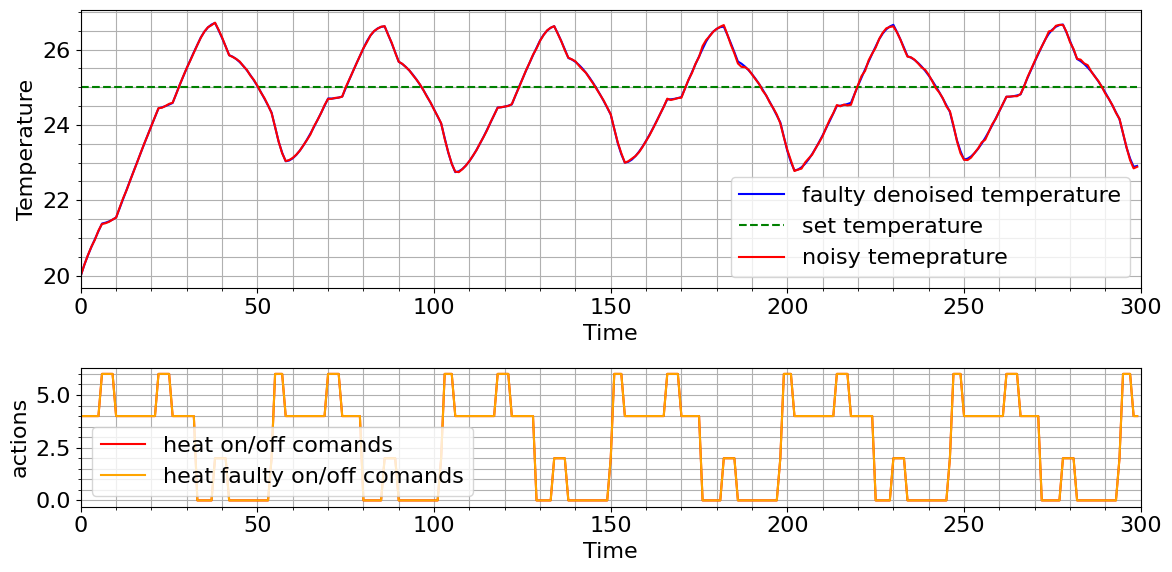

-14.949999999999989

In [ ]:
n0=0
t_set=298.15-kelvin
fig, axs = plt.subplots(2, 1,gridspec_kw={'height_ratios': [2, 1]})
fig.set_figwidth(12)
fig.set_figheight(6)
axs[0].plot(t_f[n0], 'b',label="faulty denoised temperature")
#axs[0].plot(t_out_f[n0], 'black',label="outside temperature")
axs[0].plot(t_set*np.ones(300), 'g',label="set temperature",linestyle='dashed')
axs[0].plot(noisy_t_f[n0], 'r',label="noisy temeprature")
axs[0].set_xlim(0, 300)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].grid(which = "minor")
axs[0].minorticks_on()
axs[0].legend()
axs[1].plot(a_f[n0], 'r',label="heat on/off comands")
#axs[1].plot(vent_f[0], 'b',label="ventilation on/off comands")
axs[1].plot(a_fault[n0], 'orange',label="heat faulty on/off comands")
#axs[1].plot(vent_fault[0], 'green',label="ventilation faulty on/off comands")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('actions')
axs[1].grid(True)
axs[1].legend()
axs[1].grid(which = "minor")
axs[1].minorticks_on()
fig.tight_layout()
plt.show()
t_out_f[n0,0]

In [ ]:
num=fault_type
level="low"
dir="/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_fault_"+str(num)+"_"+str(level)+"_noise.npz"

np.savez_compressed(dir, t_out_f=t_out_f, t_f=t_f,noisy_t_f=noisy_t_f,a_f=a_f,a_fault=a_fault)

# Data uploading

## train and test datasets

In [ ]:
#number_of_pieces = 8
session_length = 300

#upload train data and break it into the basic vectors
data= np.load("/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v7.npz")
#data= np.load("/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_heatingonly.npz")
t_out_c=data["t_out_c"]
t_c=data["t_c"]
noisy_t_c=data["noisy_t_c"]
a_c=data["a_c"]
# the same for test dataset
#t_out_c=t_out_c[number_of_pieces:,:]
#t_c=t_c[number_of_pieces:,:]
#noisy_t_c=noisy_t_c[number_of_pieces:,:]
#a_c=a_c[number_of_pieces:,:]
data_test= np.load("/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v8_test.npz")
#data_test= np.load("/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_noise_effect_test.npz")
t_out_c_test=data_test["t_out_c"]
t_c_test=data_test["t_c"]
noisy_t_c_test=data_test["noisy_t_c"]
a_c_test=data_test["a_c"]
'''evironment initialization'''
t_set=298.15
v_set=40
dt= 0
dv= 5
#t_out_c_test=t_out_c_test[number_of_pieces:,:]
#t_c_test=t_c_test[number_of_pieces:,:]
#noisy_t_c_test=noisy_t_c_test[number_of_pieces:,:]
#a_c_test=a_c_test[number_of_pieces:,:]

'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 8
session_length = 300
s_length = number_of_pieces * session_length


## 2400 minute dataset

In [ ]:
number_of_pieces = 5
session_length = 2400
s_length = number_of_pieces * session_length
data_test= np.load("/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v7_test_10x.npz")
t_out_c_test=data_test["t_out_c"]
t_c_test=data_test["t_c"]
noisy_t_c_test=data_test["noisy_t_c"]
a_c_test=data_test["a_c"]

In [ ]:
t_c_test.shape

(8995, 2400)

## DR dataset

In [ ]:
number_of_pieces = 1
session_length = 300
#data_dr= np.load("/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v5_dr_train.npz")
#data_dr= np.load("/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v5_dr_train_heating.npz")
data_dr= np.load("/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v5_dr_train_cooling.npz")
#data_dr= np.load("/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v5_dr.npz")
t_out_dr=data_dr["t_out_dr"]
t_dr=data_dr["t_dr"]
noisy_t_dr=data_dr["noisy_t_dr"]
a_dr=data_dr["a_dr"]
dr=data_dr['dr']
index=data_dr['index']
conf_lim=data_dr['conf_lim']
'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5



## Faulty data

In [ ]:
number_of_pieces = 1
session_length = 300

num=0
level="low"
dir="/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_fault_"+str(num)+"_"+str(level)+"_noise.npz"
data_f= np.load(dir)



#
t_out_f=data_f["t_out_f"]
t_f=data_f["t_f"]
noisy_t_f=data_f["noisy_t_f"]
a_f=data_f["a_f"]
a_fault=data_f['a_fault']

'''evironment initialization'''
t_set=298.15-kelvin
v_set=40
dt= 1
dv= 5


# NN structure

In [ ]:
number_of_hid_units = 3


'''conv 1d layer, is needed for denoising'''
'''input_value: input tensor of shape (batch_size, width, channels_in)
   channels_in: number of input channels
   channels_out: number of output channels
   name: name
   activation: if True, apply ELU function to output, if False, keep output linear'''
def conv_1d_layer(input_value, channels_in, channels_out, name, activation=True, filter_size=16):
    with tf.name_scope(name):
        w = tf.compat.v1.get_variable(shape=(filter_size, channels_in, channels_out), name='w'+name, initializer=tf.initializers.he_uniform())
        b = tf.Variable(tf.zeros([channels_out]), name='b'+name)
        conv = tf.nn.conv1d(input_value, w, 1, "SAME", name='conv')
        if activation == True:
            act = tf.nn.elu(conv + b)
        else:
            act = conv + b
    return act

'''training of the model'''
'''sess: input tf. session
   states: set of states (temperatures)
   actions: set of actions
   t_out: set of outdoor temperatures
   number_of_steps: number of training steps'''
def train(sess, states, actions, t_out, number_of_steps=10000):

    '''losses set'''
    losses = []

    '''training loop'''
    for i in tqdm(range(number_of_steps),desc='iterations',position=1,leave=False ):
        l = sess.run([loss, train_step], feed_dict={actions_ph:actions, states_ph:states,\
                                                  eps_ph:np.random.randn(actions.shape[0], actions.shape[1]), t_out_ph:t_out, initial_state:np.random.randn(states.shape[0], number_of_hid_units)})[0]
        losses.append(l)

        '''plotting'''
        if i%100==99:

            '''Denoised t and its std'''
            pred_t, sigma_t = t_denoising(sess, states[10], t_out[10], actions[10])

            '''True dynamics and its noisy version'''
            true_noisy_t =  states[10]
            true_t=t_c[k*500+10]
            print('i:',i)
            print('k:',k)

            '''plotting'''
            fig1 = plt.figure()
            fig1.set_figwidth(8)
            fig1.set_figheight(6)
            plt.ylabel('Temperature')
            plt.xlabel('Time')
            plt.plot(true_noisy_t, 'black',linewidth=0.6)
            plt.plot(true_t, 'black',linewidth=1.2)
            plt.plot(pred_t, 'red',linewidth=1.2)
            plt.fill_between(range(pred_t.shape[0]), pred_t - 3*sigma_t, pred_t + 3*sigma_t,
                     color='red', alpha=0.3)
            plt.legend([r'$\rm T_{obs}$',r'$\rm T_{true}$', r'$ \rm T_{denoised}$',r'$\rm T_{denoised} \pm 3 \sigma $'],loc=1)
            plt.savefig(fname='fig.pdf', format='pdf')
            plt.grid(True)
            plt.grid(which = "minor")
            plt.minorticks_on()

            #fig2 = plt.figure()
            #plt.xlabel('Time')
            #plt.ylabel('Temperature with 3*std')

            fig3 = plt.figure()
            plt.ylabel('loss')
            plt.xlabel('epoch num')
            #plt.yscale('log')
            plt.plot(losses, 'blue')
            plt.show()

            '''returns set of losses'''
    return losses

'''denoising of temperature'''
'''sess: input session
   noisy_t: observed temperature (with noise)
   t_out: outdoor temperature
   action: set of actions'''
def t_denoising(sess, noisy_t, t_out, action):
    data = sess.run([state_out], feed_dict={actions_ph:action.reshape((1, -1)), states_ph:noisy_t.reshape((1, -1)), t_out_ph:t_out.reshape((1, -1))})[0]
    pred_t = data[0, :, 0]
    sigma_t = np.exp(data[0, :, 1]/2)

    '''returns tuple of denoised temperature and std deviation'''
    return pred_t, sigma_t

'''FC net for hidden GRU state processing'''
'''Input: input tensor
   weights: dict of weights
   name: name'''
def dynamics_net(Input, weights, name):
    with tf.name_scope(name):
        h1 = tf.matmul(Input, weights['W1']) + weights['b1']
        h1 = tf.nn.elu(h1)
        return tf.matmul(h1, weights['W2']) + weights['b2']

In [ ]:
'''extraction of the hidden state from historical data'''
'''t: temperatures
   actions: actions
   t_out: outdoor temperature'''
def extract_hidden_state(t, actions, t_out):
    '''returns hidden state of GRU'''
    return sess.run(new_hidden_state, \
           feed_dict={hidden_actions_ph:actions,\
           hidden_states_ph:t,\
           hidden_t_out_ph:t_out,\
           initial_state:np.random.randn(t.shape[0], number_of_hid_units)})

'''prediction of dynamics'''
'''t: current temperature
   action: current action
   t_out: current outdoor temperature
   in_rnn_state: current hidden state of GRU'''
def dyn_predict(t, action, t_out, in_rnn_state):
    '''returns tuple of (new temperature, new hidden state of GRU)'''
    return sess.run([new_pred, pred_state],\
           feed_dict={pred_actions_ph:action.reshape((1, 1)),\
           pred_states_ph:t.reshape((1, 1)),\
           pred_t_out_ph:t_out.reshape((1, 1)),\
           initial_state:in_rnn_state})

In [ ]:
'''Main tf. graph'''

'''length of one session'''
learning_rate = 0.0005

'''min and max temperature'''
#t_min = 213.15
#t_max = 313.15

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

'''initial state of GRU rnn (hidden)'''
initial_state = tf.compat.v1.placeholder(shape=(None, number_of_hid_units), dtype=tf.float32, name='initial_state')

'''GRU net initialization (rnn_net is graph node which returns transformation after rnn)'''
with tf.compat.v1.name_scope('rnn_net'):
    Input = tf.compat.v1.keras.layers.Input(shape=(None, 6))
    Output = tf.compat.v1.keras.layers.CuDNNGRU(units=number_of_hid_units, return_sequences=True, return_state=True)(Input, initial_state=initial_state)
    rnn_net = tf.compat.v1.keras.Model(inputs=Input, outputs=Output)


'''below, main building blocks of main graph'''


#####log variances of normal noise in dynamical system and in observations respectively####
s = tf.constant(-5, dtype=tf.float32, name='log_variance_transition')
eta = tf.Variable(-5, dtype=tf.float32, name='log_variance_measurement')
###########################################################################################

####weights which parametrize FC net after GRU cell########################################
with tf.compat.v1.name_scope('weights'):
    weights = {}
    weights['W1'] = tf.compat.v1.get_variable(shape=(number_of_hid_units, 16), dtype=tf.float32, name='W1')
    weights['b1'] = tf.compat.v1.get_variable(shape=(16,), dtype=tf.float32, name='b1')
    weights['W2'] = tf.compat.v1.get_variable(shape=(16, 1), dtype=tf.float32, name='W2')
    weights['b2'] = tf.compat.v1.get_variable(shape=(1,), dtype=tf.float32, name='b2')
###########################################################################################

####placeholders for actions, tamp. (states_ph), temp. outside, auxiliary random variables#
actions_ph = tf.compat.v1.placeholder(shape=(None, session_length), dtype=tf.int32, name='actions_ph')
states_ph = tf.compat.v1.placeholder(shape=(None, session_length), dtype=tf.float32, name='states_ph')
eps_ph = tf.compat.v1.placeholder(shape=(None, session_length), dtype=tf.float32, name='eps_ph')
t_out_ph = tf.compat.v1.placeholder(shape=(None, session_length), dtype=tf.float32, name='t_out_ph')
###########################################################################################

####concatenation of states and actions####################################################
states_and_actions = tf.concat([tf.expand_dims(tf.cast(actions_ph, dtype=tf.float32),\
              axis=-1), tf.expand_dims(states_ph, axis=-1),\
                                tf.expand_dims(t_out_ph, axis=-1)], axis=-1, name='concat')
###########################################################################################


#####decoder (denoiser)####################################################################
conv1 = conv_1d_layer(states_and_actions, 3, 8, filter_size=8, name='conv1')
conv2 = conv_1d_layer(conv1, 8, 32, filter_size=8, name='conv2')
conv3 = conv_1d_layer(conv2, 32, 8, filter_size=8, name='conv3')
state_out = conv_1d_layer(conv3, 8, 2, filter_size=8, name='conv4', activation=False)
with tf.compat.v1.name_scope('separation'):
    #hidden variables
    mu = state_out[:, :, 0]
    #variance of hidden variables
    sigma = state_out[:, :, 1]
###########################################################################################

####one hot representation of actions######################################################
one_hot_action = tf.one_hot(actions_ph, axis=-1, depth=4, name='one_hot_action')
###########################################################################################

####data preparation before passing through dynamical map##################################
with tf.compat.v1.name_scope('true_state'):
    true_state = mu + tf.exp(sigma/2) * eps_ph

input_for_transformation = tf.concat([one_hot_action, tf.expand_dims(true_state, axis=-1), \
                                      tf.expand_dims(t_out_ph, axis=-1)]\
                                     , axis=-1, name='input_for_transformation')
###########################################################################################

####passing through dynamical map##########################################################
with tf.compat.v1.name_scope('dynamical_rnn'):

    rnn_out, _ = rnn_net(input_for_transformation)
    dyn_out = tf.reshape(dynamics_net(tf.reshape(rnn_out, \
                                shape=(-1, number_of_hid_units)), weights, 'fc'), shape=(-1, session_length))
    new_state = dyn_out + true_state

###########################################################################################

####shifting data in time##################################################################
with tf.compat.v1.name_scope('time_shift'):
    mu = mu[:, 1:]
    sigma = sigma[:, 1:]
    T = states_ph[:, 1:]
    eps = eps_ph[:, 1:]
    F = new_state[:, :-1]
###########################################################################################


####sigma term#############################################################################
with tf.compat.v1.name_scope('sigma_term'):
    sigma_term = tf.exp(sigma) * (1 / (2 * tf.exp(s)) + 1 / (2 * tf.exp(eta)))
###########################################################################################

####regularization term####################################################################
with tf.compat.v1.name_scope('regularization_term'):
    regularization_term = tf.pow(mu - F, 2) / (2 * tf.exp(s))
###########################################################################################

####log sigma term#########################################################################
with tf.compat.v1.name_scope('log_sigma_term'):
    log_sigma_term = -sigma/2
###########################################################################################

####regression term########################################################################
with tf.compat.v1.name_scope('regression_term'):
    regression_term = tf.pow(T - mu, 2) / (2 * tf.exp(eta))
###########################################################################################

####loss function##########################################################################
with tf.compat.v1.name_scope('loss'):
    loss = tf.reduce_mean(sigma_term + regularization_term + \
                          log_sigma_term + regression_term + s/2 + eta/2)
###########################################################################################

####training###############################################################################
with tf.compat.v1.name_scope('train'):
    train_step = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss)

###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################

'''auxiliary piece of graph, which is responsible for extracting hidden state of GRU via passing
previous visible states to GRU'''

################placeholders for actions, temp. (hidden_states_ph) and outside temp.#######
hidden_actions_ph = tf.compat.v1.placeholder(shape=(None, None), dtype=tf.int32, name='hidden_actions_ph')
hidden_states_ph = tf.compat.v1.placeholder(shape=(None, None), dtype=tf.float32, name='hidden_states_ph')
hidden_t_out_ph = tf.compat.v1.placeholder(shape=(None, None), dtype=tf.float32, name='hidden_t_out_ph')
###########################################################################################

######################one hot representation of the actions################################
hidden_one_hot_action = tf.one_hot(hidden_actions_ph, axis=-1, depth=4, name='hidden_one_hot_action')
###########################################################################################

#####################preparing data for passing through dynamical net######################
hidden_input_for_transformation = tf.concat([hidden_one_hot_action, tf.expand_dims(hidden_states_ph, axis=-1), \
                                      tf.expand_dims(hidden_t_out_ph, axis=-1)]\
                                     , axis=-1, name='hidden_input_for_transformation')
###########################################################################################


##########################hidden state of GRU (new_hidden_state)###########################
_, new_hidden_state = rnn_net(hidden_input_for_transformation)
###########################################################################################

###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################

'''auxiliary piece of graph, which is responsible for prediction of dynamics'''

################placeholders for actions, temp. (hidden_states_ph) and outside temp.#######
pred_actions_ph = tf.compat.v1.placeholder(shape=(None, 1), dtype=tf.int32, name='pred_actions_ph')
pred_states_ph = tf.compat.v1.placeholder(shape=(None, 1), dtype=tf.float32, name='pred_states_ph')
pred_t_out_ph = tf.compat.v1.placeholder(shape=(None, 1), dtype=tf.float32, name='pred_t_out_ph')
###########################################################################################

######################one hot representation of the actions################################
pred_one_hot_action = tf.one_hot(pred_actions_ph, axis=-1, depth=4, name='pred_one_hot_action')
###########################################################################################

#####################preparing data for passing through dynamical net######################
pred_input_for_transformation = tf.concat([pred_one_hot_action, tf.expand_dims(pred_states_ph, axis=-1), \
                                      tf.expand_dims(pred_t_out_ph, axis=-1)]\
                                     , axis=-1, name='pred_input_for_transformation')
###########################################################################################

########################next state prediction (new_pred)###################################
with tf.compat.v1.name_scope('pred_rnn'):

    pred_out, pred_state = rnn_net(pred_input_for_transformation)
    pred_dyn = tf.reshape(dynamics_net(tf.reshape(pred_out, \
                                shape=(-1, number_of_hid_units)), weights, 'fc_pred'), shape=(-1, 1))
    new_pred = pred_dyn + pred_states_ph
###########################################################################################

'''saver initialization'''
saver = tf.compat.v1.train.Saver(save_relative_paths=True)

# test functions


In [ ]:
#functions for test, scoring and progress saving.

def evaluation_step(t,t_hat):
  """
  return mse,mae,rmse,r^2 for a single sequence of data
  t= test denoised room temperature for the corresponding predicted time, same size as predicted temperature  (data)
  t_hat= predicted test denoised room temperature (prediction)
  """
  # Define the lengths for which to calculate the metrics
  lengths = [5, 10 , 15, 20, 150]

  # Initialize an empty list to store the results
  results = []

  # Calculate the metrics for each length
  for length in lengths:
    # Truncate the time series to the desired length
    ts1 = t[:length]
    ts2 = t_hat[:length]

    # Calculate the metrics
    mse = mean_squared_error(ts1, ts2)
    mae = mean_absolute_error(ts1, ts2)
    r2 = r2_score(ts1, ts2)

    # Append the results to the list
    results.append({
        'Length': length,
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    })

  # Convert the results to a DataFrame
  results_df = pd.DataFrame(results)
  return results_df


def test_step( t, a, t_out):



  '''historical data for extracting GRU hidden state'''
  t_hist = t[:150].reshape((1, -1))
  a_hist = a[:150].reshape((1, -1))
  t_out_hist = t_out[:150].reshape((1, -1))

  '''future data, we are going to predict'''
  t_future = t[150:]
  a_future = a[150:]
  t_out_future = t_out[150:]

  '''current temperature of prediction'''
  s = np.array(t[150])

  '''extraction of hidden GRU state using historical data'''
  in_rnn_state = extract_hidden_state( t_hist, a_hist, t_out_hist)
  '''initializing t collection'''
  t_test = []
  for i in range(session_length-150):
    '''update temperature (s) and hidden GRU state'''
    s, in_rnn_state = dyn_predict(s, a_future[i], t_out_future[i], in_rnn_state)

    '''adding to t collection'''
    t_test.append(s)

  t_test = np.array(t_test).flatten()
  return t_future,t_test

def test_batch( t, a, t_out,size):
  """

  Args:
    t: denoised modelled room temperature
    a:modelled HVAC action coded vector
    t_out: Mocelled temperature outside of the room
    size: int- select the first n elements of the passed test dataset

  Returns:
    t_test_final: nested list with all the predicted temperatures, each list one data sequence
    mse_f:list of mse for each data sequence
    mae_f:list of mae for each data sequence
    rmse_f:list of rmse for each data sequence
    r2_f: list of r2 for each data sequence

  """

  t_test_final=[]
  mse_f=[]
  mae_f=[]
  r2_f=[]
  zeros=np.zeros((5,4))
  df1=pd.DataFrame(zeros,columns=['Length', 'MSE', 'MAE', 'R2'])
  if size<= len(t):
    for i in tqdm(range(size)):
      t_future,t_test=test_step( t[i], a[i], t_out[i])
      t_test_final.append(t_test)
      df= evaluation_step(t_future,t_test)
      df_150=df.loc[df['Length'] == 150]
      mse_f.append(df_150['MSE'].values[0])
      mae_f.append(df_150['MAE'].values[0])
      r2_f.append(df_150['R2'].values[0])
      df1=(df1+df)

  else:
    print("Error: the data set is smaller than the given size")
    t_test_final.append(np.nan)
    mse_f.append(np.nan)
    mae_f.append(np.nan)
    r2_f.append(np.nan)

  return t_test_final, mse_f, mae_f, r2_f,df1/size

def DR_test_batch( t, a, t_out,dr, index, confort_lim, size):
  """

  Args:
    t: denoised modelled room temperature
    a:modelled HVAC action coded vector
    t_out: Mocelled temperature outside of the room
    size: int- select the first n elements of the passed test dataset

  Returns:
    t_test_final: nested list with all the predicted temperatures, each list one data sequence


  """

  t_test_final=[]
  index_pred=[]
  offset=[]
  offset_pred=[]

  if size<= len(t):
    for i in tqdm(range(size)):
      start=dr[i].nonzero()[0][0]-1
      a[i,start:]=0
      t_future,t_test=test_step( t[i], a[i], t_out[i])
      t_test_final.append(t_test)
      if np.count_nonzero((abs(t_test[start-150:]-conf_lim[i])<0.15))>0:
        index_pred_i=(abs(t_test[start-150:]-conf_lim[i])<0.15).nonzero()[0][0]+start
        if index[i][0]==0:
          offset.append(299-start)
        else:
          offset.append(index[i][0]-start)
        offset_pred.append(index_pred_i-start)
      else:
        index_pred_i=0
        offset.append(0)
        offset_pred.append(0)
      index_pred.append(index_pred_i)


  else:
    print("Error: the data set is smaller than the given size")
    t_test_final.append(np.nan)

  offset=np.array(offset)
  offset_pred=np.array(offset_pred)
  bias=offset_pred-offset

  return t_test_final, index_pred,offset,offset_pred,bias
def save_progress(filepath, mae, mse, r2):
    # Definir el nombre de las columnas
    columnas = ["timestamp", "MAE", "MSE",  "R2"]

    # Crear el archivo si no existe
    file_exists = os.path.isfile(filepath)

    # Abrir el archivo en modo append
    with open(filepath, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=columnas)

        # Si el archivo no existía, escribir el encabezado
        if not file_exists:
            writer.writeheader()

        # Obtener el timestamp actual
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

        # Crear el diccionario con los valores
        row = {
            "timestamp": timestamp,
            "MAE": mae,
            "MSE": mse,
            "R2": r2
        }

        # Escribir la fila en el archivo
        writer.writerow(row)


def plot_progress(filepath, n):
    # Leer el archivo CSV en un DataFrame de pandas
    try:
        df = pd.read_csv(filepath, parse_dates=['timestamp'])
    except FileNotFoundError:
        print(f"El archivo {filepath} no existe.")
        return

    # Verificar si el DataFrame tiene las columnas necesarias
    columnas_necesarias = ["timestamp", "MAE", "MSE", "R2"]
    for columna in columnas_necesarias:
        if columna not in df.columns:
            print(f"Falta la columna {columna} en el archivo CSV.")
            return

    # Establecer la columna 'timestamp' como el índice del DataFrame
    df.set_index('timestamp', inplace=True)

    # Filtrar los últimos n registros
    df = df.tail(n)

    # Crear la figura y los subplots
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 12), sharex=True)
    axes[0].set_title("Metrics")

    # Graficar cada columna en un subplot separado
    for i, columna in enumerate(columnas_necesarias[1:]):  # Saltar "timestamp"
        axes[0].plot(df.index, df[columna], label=columna)

        axes[0].set_ylabel(str(columna))
        axes[0].legend()

    # Añadir etiqueta al eje x en el último subplot
    axes[-1].set_xlabel('Timestamp')

    # Ajustar el layout para que no se sobrepongan los subplots
    plt.tight_layout()

    # Mostrar la gráfica
    plt.show()

def test_batch_fault( t, a, t_out,size):
  """

  Args:
    t: denoised modelled room temperature
    a:modelled HVAC action coded vector
    t_out: Mocelled temperature outside of the room
    size: int- select the first n elements of the passed test dataset

  Returns:
    t_test_final: nested list with all the predicted temperatures, each list one data sequence
    mse_f:list of mse for each data sequence
    mae_f:list of mae for each data sequence
    rmse_f:list of rmse for each data sequence
    r2_f: list of r2 for each data sequence

  """

  t_test_final=[]
  if size<= len(t):
    for i in tqdm(range(size)):
      t_future,t_test=test_step( t[i], a[i], t_out[i])
      t_test_final.append(t_test)

  else:
    print("Error: the data set is smaller than the given size")
    t_test_final.append(np.nan)

  return t_test_final
def fault_response_time(t_matrix, t_hat_matrix, window_size, reference_value, rmse_threshold, RMSE=True):
    num_vectors, vector_length = t_matrix.shape
    indices = []  # To store the end index where RMSE exceeds the reference value
    start = []  # To store the starting index where RMSE falls below rmse_threshold

    for i in range(num_vectors):
        t = t_matrix[i]
        t_hat = t_hat_matrix[i]

        # Create a matrix where each row is a sliding window for the current vector
        t_windows = np.lib.stride_tricks.sliding_window_view(t, window_shape=window_size)
        t_hat_windows = np.lib.stride_tricks.sliding_window_view(t_hat, window_shape=window_size)

        # Vectorized calculation of RMSE (or simple error) for each window
        if RMSE:
            errors = np.sqrt(np.mean((t_windows - t_hat_windows) ** 2, axis=1))  # RMSE
        else:
            errors = np.mean(np.abs(t_windows - t_hat_windows), axis=1)  # Mean absolute error (if not RMSE)

        # Find the first window where error exceeds the reference value
        exceeding_index = np.argmax(errors > reference_value)

        # If no window exceeds the reference value, default to 150
        if errors[exceeding_index] <= reference_value:
            indices.append(150)
            start.append(150)
        else:
            # Find the first window before exceeding_index where error falls below rmse_threshold
            pre_exceeding_errors = errors[:exceeding_index]

            # Only check for `rmse_threshold` if there are valid windows before `exceeding_index`
            if len(pre_exceeding_errors) > 0:
                reverse_index = np.argmax(np.flip(pre_exceeding_errors) < rmse_threshold)
                # Check if a valid index was found (flip didn't find any valid window)
                if np.flip(pre_exceeding_errors)[reverse_index] >= rmse_threshold:
                    start.append(150)  # No point found below threshold
                else:
                    start.append(exceeding_index - reverse_index - 1 + window_size - 1)
            else:
                start.append(150)  # No valid windows before exceeding_index

            indices.append(exceeding_index + window_size - 1)
    return np.array(indices), np.array(start)








# Network recovery

In [ ]:
#appened the saved graph to the current graph
#saver = tf.compat.v1.train.import_meta_graph('/content/drive/MyDrive/Colab Notebooks/BML models/model 7/backup/Model_V7-100.meta')
saver = tf.compat.v1.train.import_meta_graph('/content/drive/MyDrive/Colab Notebooks/BML models/final model/general model/Model_V7-100.meta')

In [ ]:

sess = tf.compat.v1.Session()
#saver.restore(sess,tf.compat.v1.train.latest_checkpoint('/content/drive/MyDrive/Colab Notebooks/BML models/model 7/backup/'))
saver.restore(sess,tf.compat.v1.train.latest_checkpoint('/content/drive/MyDrive/Colab Notebooks/BML models/final model/general model/'))
# Access saved Variables directly
w2_r=sess.run('W2:0')
print(w2_r)


InvalidArgumentError: Restoring from checkpoint failed. This is most likely due to a mismatch between the current graph and the graph from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Graph execution error:

Detected at node 'rnn_net/cu_dnngru/CudnnRNNV2' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start
    File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
    File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
    File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
    File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
    File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
    File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
    File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
    File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
    File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
    File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
    File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
    File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
    File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
    File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    File "<ipython-input-6-09fc307ca7be>", line 19, in <cell line: 0>
    File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/base_rnn.py", line 626, in __call__
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer_v1.py", line 838, in __call__
    File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/base_cudnn_rnn.py", line 104, in call
    File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/cudnn_gru.py", line 184, in _process_batch
Node: 'rnn_net/cu_dnngru/CudnnRNNV2'
No OpKernel was registered to support Op 'CudnnRNNV2' used by {{node rnn_net/cu_dnngru/CudnnRNNV2}} with these attrs: [dropout=0, input_mode="linear_input", is_training=true, direction="unidirectional", rnn_mode="gru", seed=0, T=DT_FLOAT, seed2=0]
Registered devices: [CPU]
Registered kernels:
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_BFLOAT16]
  device='GPU'; T in [DT_HALF]

	 [[rnn_net/cu_dnngru/CudnnRNNV2]]

# Initial Training

In [ ]:
'''Training'''
#tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.Session()
init = tf.compat.v1.global_variables_initializer()
sess.run(init)
K=0
I=10
j=I+1
for i in range(K,I):
  n_t=np.round(noisy_t_c[500*i:500*j,:],2)
  a_t=np.round(a_c[500*i:500*j,:],2)
  t_o=np.round(t_out_c[500*i:500*j,:],2)
  losses = train(sess, n_t,a_t,t_o, number_of_steps=300)
  saver.save(sess, '/content/drive/MyDrive/Colab Notebooks/BML models/model 7/backup/Model_V8',global_step=100)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
noisy_t_c.shape

(79984, 300)

# continued training

In [ ]:
noisy_t_c.shape

(100000, 300)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

i: 99
k: 53


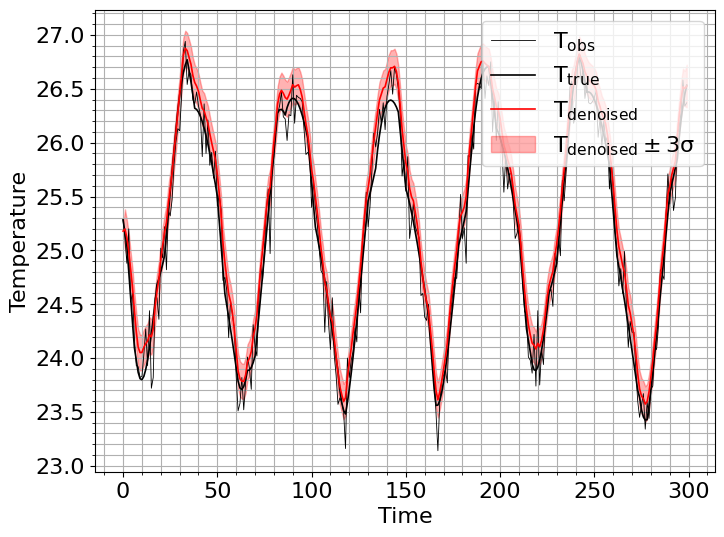

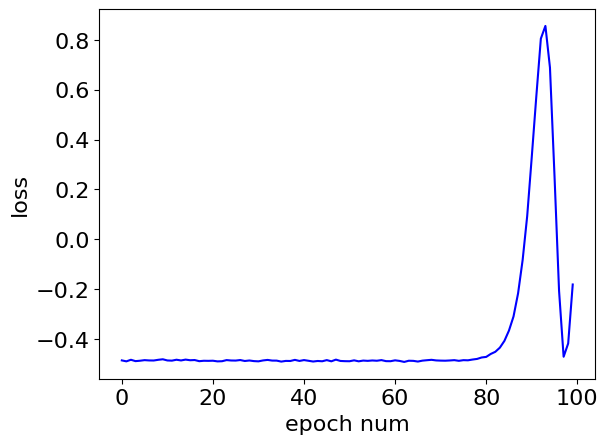

i: 199
k: 53


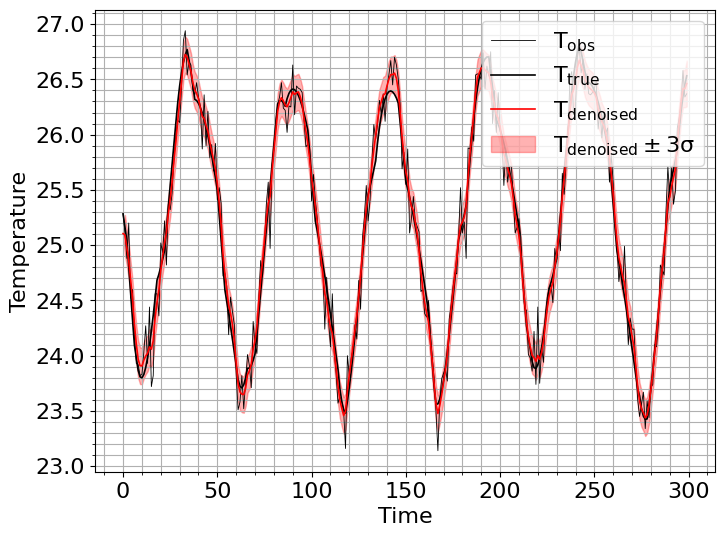

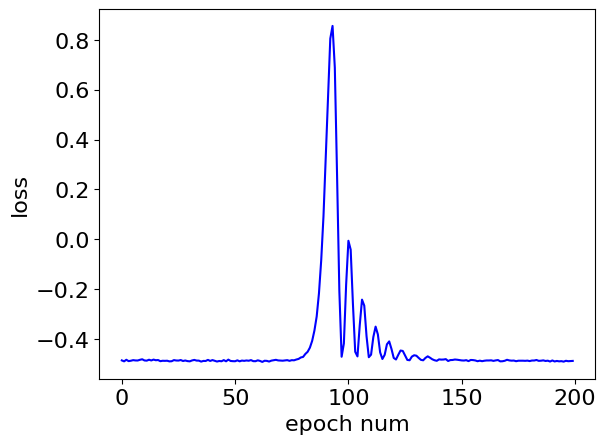

i: 299
k: 53


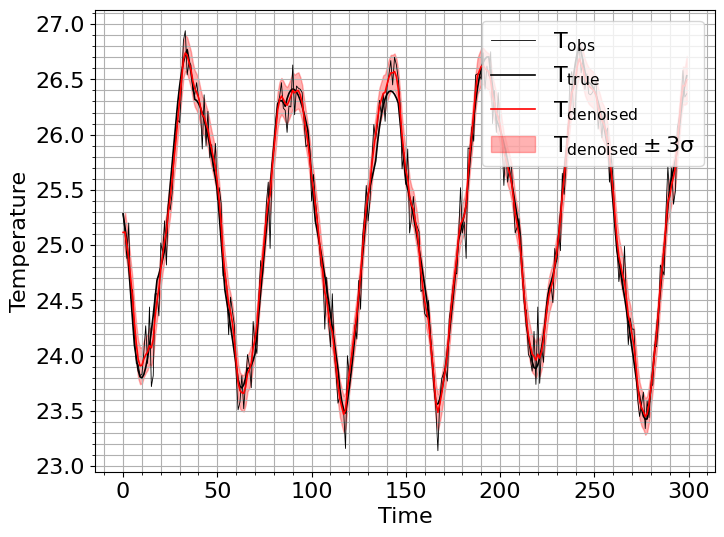

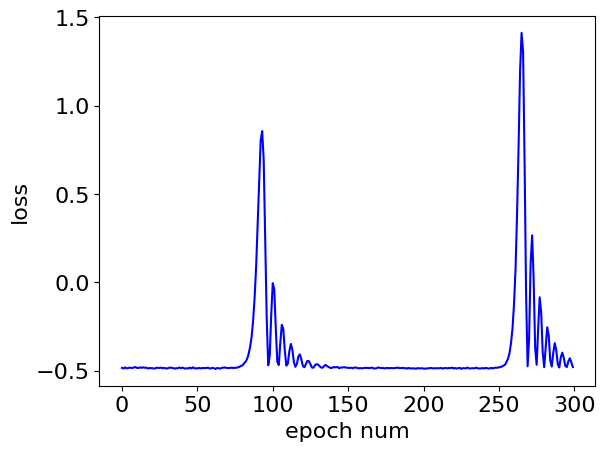

i: 399
k: 53


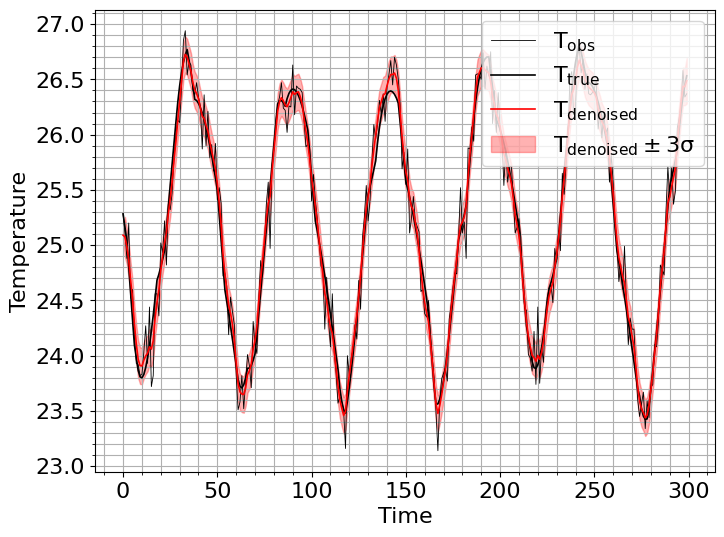

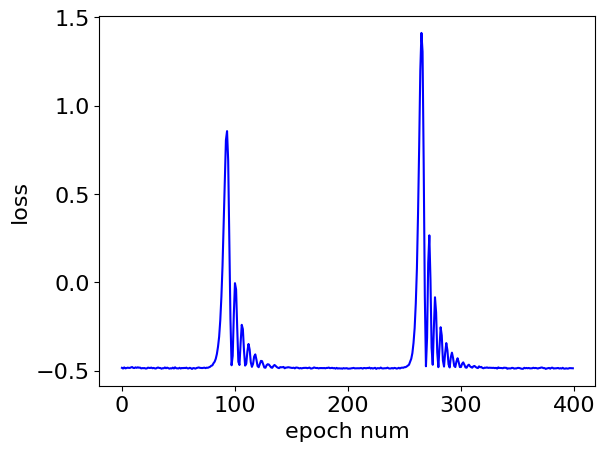

i: 499
k: 53


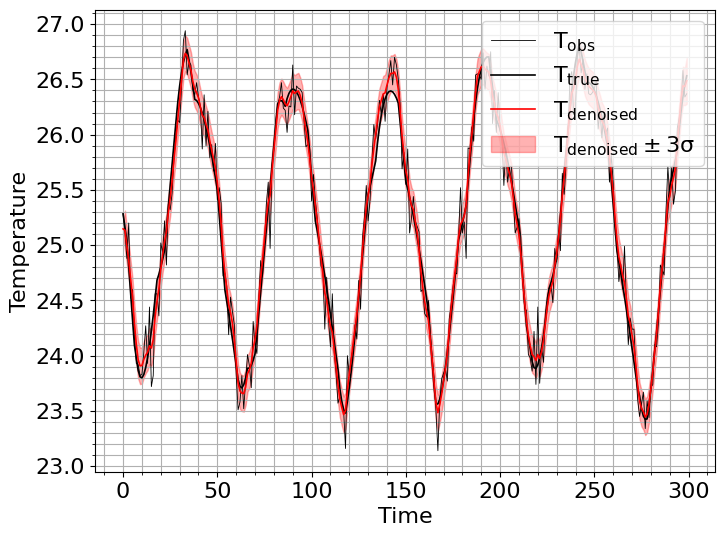

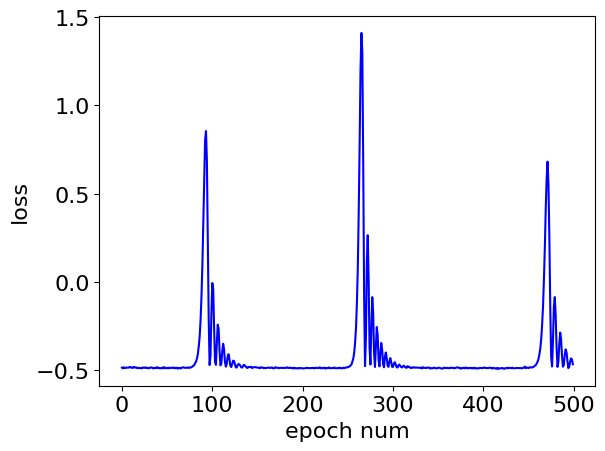

KeyboardInterrupt: 

In [ ]:
'''Training'''
K=53
I=54
for k in tqdm(range(K,I),desc='epoch', position=0,leave=False):
  n_t=np.round(noisy_t_c[500*k:500*(k+1),:],2)
  a_t=np.round(a_c[500*k:500*(k+1),:],2)
  t_o=np.round(t_out_c[500*k:500*(k+1),:],2)
  losses = train(sess, n_t,a_t,t_o, number_of_steps=1000)
  #losses = train(sess, noisy_t, a, t_out, number_of_steps=10000)
 # saver.save(sess, '/content/drive/MyDrive/Colab Notebooks/BML models/model 7/Model_V7',global_step=100)
  saver.save(sess, '/content/drive/MyDrive/Colab Notebooks/BML models/model 7/backup/Model_V8',global_step=100)
  #saver.save(sess, '/content/drive/MyDrive/Colab Notebooks/BML models/Test models/my_test_model_V4',global_step=100)
  #t_t, mse, mae, rmse, r2 =test_batch( t_c_test, a_c_test, t_out_c_test,size=50)

  #mes_f=sum(mse) / len(mse)
  #mae_f=sum(mae) / len(mae)
  #rmse_f=sum(rmse) / len(rmse)
  #r2_f=sum(r2) / len(r2)
  #save_progress('/content/drive/MyDrive/Colab Notebooks/BML dataset/resultados.csv', mes_f, mae_f, rmse_f, r2_f)
  #save_progress('/content/drive/MyDrive/Colab Notebooks/BML models/Test models/results_V4.csv', mes_f, mae_f, rmse_f, r2_f)

#Testing

##testing a single prediction

[[-0.7741216   0.99999535  0.18785872]]


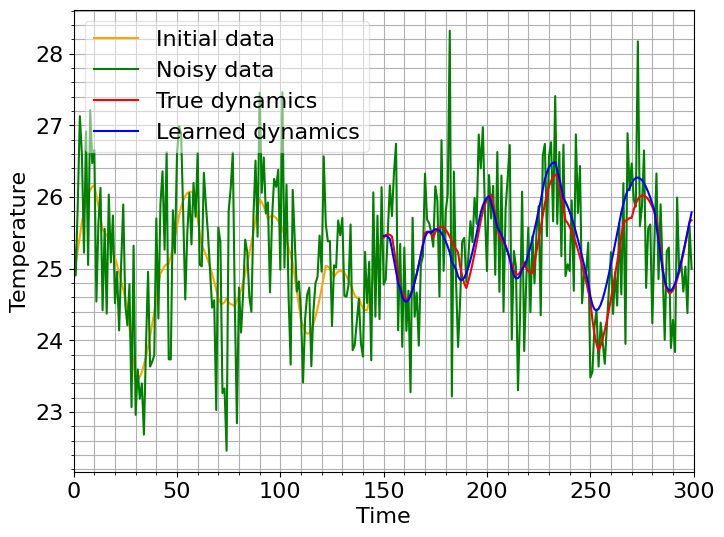

In [ ]:
'''piece of code for testing of prediction'''
"""for controlled environment"""
init_t = (298.15, 20, 298.15, 298.15, 268.85,0)
#temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
'''sample true dynamics'''
'''piece of code for testing of prediction'''

'''initializing env.'''
env_t = environment(init_t)
session_length = 600
std_of_noise = 0.8
t_set=298.15
v_set=20
dt= 1
dv= 5
'''sample true dynamics'''

t, noisy_t, a, t_out =  env_t.controlled_session(session_length, std_of_noise,t_set,v_set,dt,dv)
t_test=t[:300]-273.13
t=t[300:]-273.13

noisy_t=noisy_t[300:] -273.13
t_out=t_out[300:]-273.13
'''historical data for extracting GRU hidden state'''
a_dec= np.zeros((0,1), dtype=int)
for i in range(len(a)):
  y=to_bin(a[i])
  a_dec=np.append(a_dec,np.array([y]).reshape((1,1)), axis=0)
a_dec=a_dec[300:]
t_hist = t[:150].reshape((1, -1))
a_hist = a_dec[:150].reshape((1, -1))
t_out_hist = t_out[:150].reshape((1, -1))

'''future data, we are going to predict'''
t_future = t[150:]
a_future = a_dec[150:]
t_out_future = t_out[150:]

'''current temperature of prediction'''
s = np.array(t[150])

'''extraction of hidden GRU state using historical data'''
in_rnn_state = extract_hidden_state( t_hist, a_hist, t_out_hist)
print(in_rnn_state)
'''prediction loop'''

'''initializing t collection'''
t_test = []
for i in range(session_length-150-300):

    '''update temperature (s) and hidden GRU state'''
    s, in_rnn_state = dyn_predict(s, a_future[i], t_out_future[i], in_rnn_state)

    '''adding to t collection'''
    t_test.append(s)

t_test = np.array(t_test).flatten()

'''plotting of example'''
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)
axs.plot(range(150), t[:150],'orange',label='Initial data')
axs.plot(range(session_length-300), noisy_t,'green',label='Noisy data')
axs.plot(range(150,session_length-300), t[150:],'red',label="True dynamics")
axs.plot(range(150,session_length-300),t_test, 'blue',label="Learned dynamics")
axs.set_xlim(0, session_length-300)
axs.set_xlabel('Time')
axs.set_ylabel('Temperature')
axs.grid(True)
axs.grid(which = "minor")
axs.minorticks_on()
axs.legend(loc=0,framealpha=0.5)
plt.show()

In [ ]:
'''piece of code for testing of prediction'''
"""for controlled environment"""
init_t = (298.15, 20, 298.15, 298.15, 268.85,0)
#temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
'''sample true dynamics'''
'''piece of code for testing of prediction'''

'''initializing env.'''
env_t = environment(init_t)
session_length = 600
std_of_noise = 0.8
t_set=298.15
v_set=20
dt= 1
dv= 5
'''sample true dynamics'''

t, noisy_t, a, t_out =  env_t.controlled_session(session_length, std_of_noise,t_set,v_set,dt,dv)
t_test=t[:300]-273.13
t=t[300:]-273.13

noisy_t=noisy_t[300:] -273.13
t_out=t_out[300:]-273.13
'''historical data for extracting GRU hidden state'''
a_dec= np.zeros((0,1), dtype=int)
for i in range(len(a)):
  y=to_bin(a[i])
  a_dec=np.append(a_dec,np.array([y]).reshape((1,1)), axis=0)
a_dec=a_dec[300:]
t_hist = t[:150].reshape((1, -1))
a_hist = a_dec[:150].reshape((1, -1))
t_out_hist = t_out[:150].reshape((1, -1))

'''future data, we are going to predict'''
t_future = t[150:]
a_future = a_dec[150:]
t_out_future = t_out[150:]

'''current temperature of prediction'''
s = np.array(t[150])





 pred_t, sigma_t = t_denoising(sess, states[10], t_out[10], actions[10])

            '''True dynamics and its noisy version'''
            true_noisy_t =  states[10]

            '''plotting'''
            fig1 = plt.figure()
            plt.ylabel('Temperature')
            plt.xlabel('Time')
            plt.plot(true_noisy_t, 'black', zorder=1,linewidth=0.7)
            #plt.plot(true_t, 'green', zorder=5)
            plt.plot(pred_t, 'red', zorder=10)
            plt.fill_between(range(pred_t.shape[0]), pred_t - 3*sigma_t, pred_t + 3*sigma_t,
                     color='red', alpha=0.4, zorder=15)
            plt.legend(['Measured temperature',r'$\rm T$' 'Predicted temperature','Temperature with 3*std'])
            plt.savefig(fname='fig.pdf', format='pdf')
            #fig2 = plt.figure()
            #plt.xlabel('Time')
            #plt.ylabel('Temperature with 3*std')

            fig3 = plt.figure()
            plt.ylabel('loss')
            plt.xlabel('epoch num')
            #plt.yscale('log')
            plt.plot(losses, 'blue')
            plt.show()

In [ ]:
d = t[150:] - t_test
mse_f = np.mean(d**2)
mae_f = np.mean(abs(d))
rmse_f = np.sqrt(mse_f)
r2_f = 1-(sum(d**2)/sum((t[150:]-np.mean(t[150:]))**2))

print("Results by manual calculation:")
print("MAE:",mae_f)
print("MSE:", mse_f)
print("RMSE:", rmse_f)
print("R-Squared:", r2_f)


Results by manual calculation:
MAE: 1.6668586242467653
MSE: 3.454788243349006
RMSE: 1.8587060669586803
R-Squared: -2.2242750861459015


In [ ]:

fig.savefig('/content/drive/MyDrive/Colab Notebooks/BML figures/finetuning_cooling.pdf', format='pdf')

In [ ]:
t_c_test.shape[0]/500

89.974

In [ ]:
range(143)

range(0, 143)

## testing a batch of predictions

In [ ]:
#for n in tqdm(range(0,89),desc='epoch', position=0,leave=False):
n=0 #75 is the part of the data set that has the most similar mean metrics to the overall dataset,
#35 worse MAE, 128 worse MSE, 104  worse R2
#7 best MAE, 7 best MSE,  21  best R2
session_length=300
t_t, mse, mae,r2,df =test_batch( t_c_test[n*500:], a_c_test[n*500:], t_out_c_test[n*500:],size=498)
mse_f=sum(mse) / len(mse)
mae_f=sum(mae) / len(mae)
r2_f=sum(r2) / len(r2)
save_progress('/content/drive/MyDrive/Colab Notebooks/BML models/model 7/backup/results.csv', np.sqrt(mse_f), mae_f, r2_f)
#save_progress('/content/drive/MyDrive/Colab Notebooks/BML models/model 7/backup/selection1.csv', np.sqrt(mse_f), mae_f, r2_f)
print("\n")
print("average of evaluation metrics:")
print("MAE:",mae_f)
print("RMSE:",np.sqrt( mse_f))
print("MSE:", mse_f)
print("R-Squared:", r2_f)


print("max of evaluation metrics:")
print("MAE:",max(mae), "in the element:",mae.index(max(mae)) )
print("MSE:", max(mse), "in the element:",mse.index(max(mse)))
print("RMSE:",np.sqrt( max(mse)), "in the element:",mse.index(max(mse)))
print("R-Squared:",min(r2), "in the element:",r2.index(min(r2)) )

print("min of evaluation metrics:")
print("MAE:",min(mae), "in the element:",mae.index(min(mae)) )
print("MSE:", min(mse), "in the element:",mse.index(min(mse)))
print("RMSE:", np.sqrt( min(mse)), "in the element:",mse.index(min(mse)))
print("R-Squared:",max(r2), "in the element:",r2.index(max(r2)) )


  0%|          | 0/498 [00:00<?, ?it/s]



average of evaluation metrics:
MAE: 0.18675063393296432
RMSE: 0.24530782994158473
MSE: 0.060175931430649456
R-Squared: 0.8656315816453611
max of evaluation metrics:
MAE: 0.5430795766701048 in the element: 212
MSE: 0.3691151024789576 in the element: 212
RMSE: 0.6075484363233582 in the element: 212
R-Squared: 0.2325760666727099 in the element: 184
min of evaluation metrics:
MAE: 0.04066615787641316 in the element: 313
MSE: 0.002419836503659716 in the element: 313
RMSE: 0.049191833709059024 in the element: 313
R-Squared: 0.9947208733435655 in the element: 119


In [ ]:
df

,Length,MSE,MAE,R2
0,5.0,0.023714,0.113592,-11.126923
1,10.0,0.033000,0.133367,-0.300892
2,15.0,0.032820,0.135049,0.341404
3,20.0,0.032548,0.136242,0.732943
4,150.0,0.060176,0.186751,0.865632


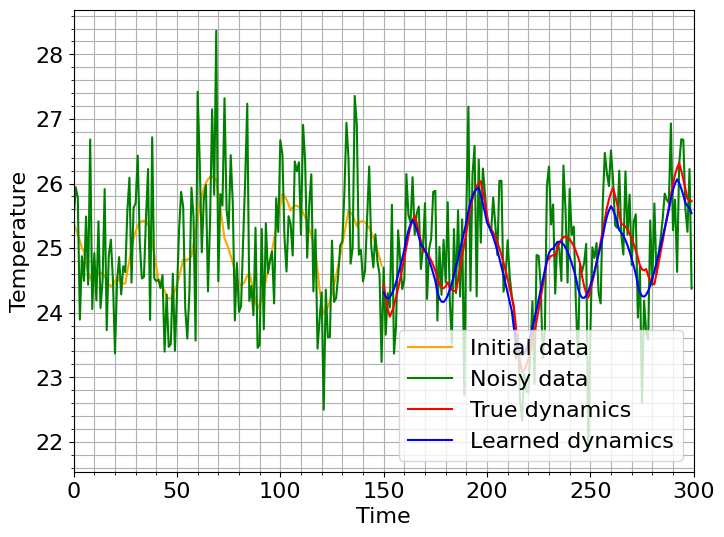

In [ ]:

k=5
session_length=300
n=0*500 +k #75 is the part of the data set that has the most similar mean metrics to the overall dataset,
#35 worse MAE, 128 worse MSE, 104  worse R2
#7 best MAE, 7 best MSE,  21  best R2
t=t_c_test[+n]
noisy_t=noisy_t_c_test[+n]
t_test=t_t[k]
t_out_c_test[n]
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)
axs.plot(range(150), t[:150],'orange',label='Initial data')
axs.plot(range(session_length), noisy_t,'green',label='Noisy data')
axs.plot(range(150,session_length), t[150:],'red',label="True dynamics")
axs.plot(range(150,session_length),t_test, 'blue',label="Learned dynamics")
axs.set_xlim(0, session_length)
axs.set_xlabel('Time')
axs.set_ylabel('Temperature')
axs.grid(True)
axs.grid(which = "minor")
axs.minorticks_on()
axs.legend(loc=4)
plt.show()

In [ ]:
t_out_c_test[:,0].max()

25.492052006176323

##Save test data

In [ ]:


def create_dataframe( list1, list2, list3, column_names=None):
    """
    Creates a pandas DataFrame from five lists, using each list as a column.

    Parameters:
    - list1, list2, list3, list4, list5: The lists to be used as columns in the DataFrame.
    - column_names: Optional list of column names. If not provided, default names will be used.

    Returns:
    - A pandas DataFrame with the provided lists as columns.
    """
    data = {
        'Column1': list1,
        'Column2': list2,
        'Column3': list3
    }

    if column_names:
        if len(column_names) != 3:
            raise ValueError("The number of column names must be exactly 4.")
        data = {column_names[i]: lst for i, lst in enumerate([list1, list2, list3])}


    df = pd.DataFrame(data)

    return df


In [ ]:
test_data=create_dataframe( mse, mae, r2,column_names=[ 'mse', 'mae', 'r2' ])
t_t_df=pd.DataFrame(zip(*t_t)).transpose()
t_df=pd.DataFrame(zip(*t_c_test[8*500:8*500+len(t_t_df)])).transpose()
test_data.to_csv('/content/drive/MyDrive/Colab Notebooks/BML models/Test models/test_metrics_10x.csv', index=False)
t_t_df.to_csv('/content/drive/MyDrive/Colab Notebooks/BML models/Test models/test_pred_10x.csv', index=False)
t_df.to_csv('/content/drive/MyDrive/Colab Notebooks/BML models/Test models/test_data_10x.csv', index=False)
df.to_csv('/content/drive/MyDrive/Colab Notebooks/BML models/Test models/test_data_windows_10x.csv', index=False)

## Restore test data

In [ ]:
test_metrics=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BML models/Test models/test_metrics_10x.csv')
test_pred=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BML models/Test models/test_pred_10x.csv')
test_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BML models/Test models/test_data_10x.csv')
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BML models/Test models/test_data_windows_10x.csv')


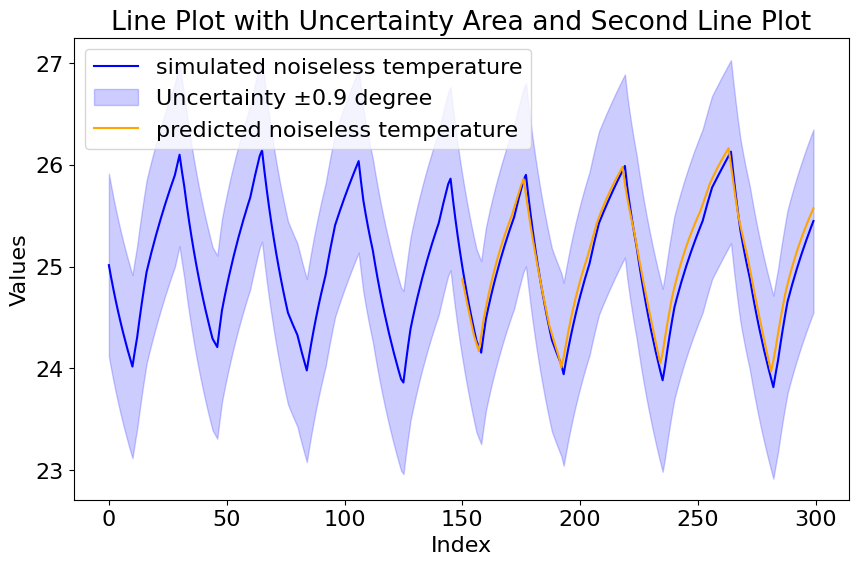

In [ ]:
number_of_pieces = 1
session_length = 300
element = 1 #ok example
n = 15  # Number of time steps for yellow highlight
consecutive_outside=0
# Extracting the rows
row1 = test_data.iloc[element]
row2 = test_pred.iloc[element].reset_index(drop=True)
comp_row = row1[150:session_length].reset_index(drop=True)
uncertainty=0.9
# X values for the plots
x1 = range(session_length)
x2 = range(150, session_length)

# Plotting
plt.figure(figsize=(10, 6))

# Line plot for the first row
plt.plot(x1, row1, label='simulated noiseless temperature', color='blue')

# Area of uncertainty
plt.fill_between(x1, row1 - uncertainty, row1 + uncertainty, color='blue', alpha=0.2, label='Uncertainty ±'+str(uncertainty)+ ' degree')

# Line plot for the second row (values 150 to 300)
plt.plot(x2, row2, label='predicted noiseless temperature', color='orange')

# Highlight areas where row2 is outside the uncertainty band
outside = (row2 < comp_row - uncertainty) | (row2 > comp_row + uncertainty)

start = None

for i in range(len(x2)):
    if outside.iloc[i]:
        if start is None:
            start = x2[i]
        consecutive_outside += 1
    else:
        if start is not None:
            if consecutive_outside <= n:
                plt.axvspan(start, x2[i-1], color='yellow', alpha=0.3)
            else:
                plt.axvspan(start, x2[i-1], color='red', alpha=0.3)
            start = None
            consecutive_outside = 0

# Check if the last segment needs highlighting
if start is not None:
    if consecutive_outside <= n:
        plt.axvspan(start, x2[-1], color='yellow', alpha=0.3)
    else:
        plt.axvspan(start, x2[-1], color='red', alpha=0.3)

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Line Plot with Uncertainty Area and Second Line Plot')
plt.legend()

# Display the plot
plt.show()

In [ ]:
def compare_rows(row1, row2, range, n):
    """
    Compares two rows and returns a series indicating whether the values in row2 are outside
    the range defined by row1 ± range for more than 'n' consecutive time steps.

    Args:
    row1 (pd.Series): The first row to compare (reference row).
    row2 (pd.Series): The second row to compare.
    range (float): The range for the comparison.
    n (int): The number of initial time steps to be marked separately.

    Returns:
    pd.Series: A series with values:
               0 - within the range
               1 - outside the range for the first 'n' time steps
               2 - outside the range for more than 'n' consecutive time steps
    """
    # Ensure both rows have the same length
    if len(row1) != len(row2):
        raise ValueError("Both rows must have the same number of elements")

    result = []
    consecutive_outside = 0
    outside_band = False

    for val1, val2 in zip(row1, row2):
        if val2 < val1 - range or val2 > val1 + range:
            consecutive_outside += 1
            outside_band = True
        else:
            consecutive_outside = 0
            outside_band = False

        if outside_band:
            if consecutive_outside <= n:
                result.append(1)
            else:
                result.append(2)
        else:
            result.append(0)

    return pd.Series(result)



In [ ]:
n=20
df_range1 = pd.DataFrame().reindex_like(test_pred)
for i in test_data.index.values:
  place_h= compare_rows( test_data.iloc[i][150:session_length].reset_index(drop=True), test_pred.iloc[i].reset_index(drop=True),0.25,n)
  df_range1.iloc[i]=place_h


In [ ]:
confidense_pred_1c=1-df_range1.apply(lambda row: (row >= 2).any(), axis=1).sum()/len(df_range1.sum(axis=1))

In [ ]:
confidense_pred_1c

0.278

In [ ]:
df_range05 = pd.DataFrame().reindex_like(test_pred)
for i in test_data.index.values:
  place_h= compare_rows( test_data.iloc[i][150:300].reset_index(drop=True), test_pred.iloc[i].reset_index(drop=True),0.5,n)
  df_range05.iloc[i]=place_h


In [ ]:
confidense_pred_05c=1-df_range05.apply(lambda row: (row >= 2).any(), axis=1).sum()/len(df_range05.sum(axis=1))

In [ ]:
confidense_pred_05c

0.848

In [ ]:
N=[0,5,10,15,20,25,30]
K=[30,60,90,120,150]
T=0.25

In [ ]:
 VAL=[]
 for n in N:
  val=[]
  for k in K:
    df_range1_r = pd.DataFrame().reindex_like(test_pred.iloc[:, : k])
    for i in test_data.index.values:
      place_h= compare_rows( test_data.iloc[i][150:150+k].reset_index(drop=True), test_pred.iloc[i][:k].reset_index(drop=True),T,n)
      df_range1_r.iloc[i]=place_h
    confidense_pred=1-df_range1_r.apply(lambda row: (row >= 2).any(), axis=1).sum()/len(df_range1_r.sum(axis=1))
    val.append(confidense_pred)
  VAL.append(val)


In [ ]:
VAL

[[0.0040000000000000036,
  0.0040000000000000036,
  0.0040000000000000036,
  0.0040000000000000036,
  0.0040000000000000036],
 [0.03400000000000003,
  0.008000000000000007,
  0.0040000000000000036,
  0.0040000000000000036,
  0.0040000000000000036],
 [0.18200000000000005,
  0.04600000000000004,
  0.010000000000000009,
  0.0040000000000000036,
  0.0040000000000000036],
 [0.5900000000000001,
  0.29600000000000004,
  0.14400000000000002,
  0.06799999999999995,
  0.04400000000000004],
 [0.844, 0.634, 0.43600000000000005, 0.32399999999999995, 0.278],
 [0.956, 0.868, 0.772, 0.714, 0.6579999999999999],
 [1.0, 0.968, 0.9319999999999999, 0.886, 0.872]]

In [ ]:
VAL

[[0.4698, 0.3398, 0.3044, 0.2812, 0.2612],
 [0.6726,
  0.497,
  0.43999999999999995,
  0.40080000000000005,
  0.37560000000000004],
 [0.8996, 0.7534, 0.651, 0.5602, 0.5124],
 [0.9678, 0.901, 0.834, 0.7572, 0.7021999999999999],
 [0.9774, 0.915, 0.8552, 0.7867999999999999, 0.7345999999999999],
 [0.9978, 0.9756, 0.951, 0.9208, 0.8834],
 [1.0, 0.991, 0.9828, 0.9682, 0.9546]]

In [ ]:
n=15

In [ ]:

df_range05_r = pd.DataFrame().reindex_like(test_pred.iloc[:, : 60])
for i in test_data.index.values:
  place_h= compare_rows( test_data.iloc[i][150:210].reset_index(drop=True), test_pred.iloc[i][:60].reset_index(drop=True),0.1,n)
  df_range05_r.iloc[i]=place_h
confidense_pred_05c_r=1-df_range05_r.apply(lambda row: (row >= 2).any(), axis=1).sum()/len(df_range05_r.sum(axis=1))
confidense_pred_05c_r

0.538

# test: DR


In [ ]:
t_t,index_pred,offset,offset_pred,bias = DR_test_batch( t_dr, a_dr, t_out_dr,dr, index, conf_lim, size=500)

index=index+(index==0)*300
index_pred=np.array(index_pred)
index_pred=index_pred+(index_pred==0)*300

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
np.mean(bias)

-1.824

In [ ]:
np.sqrt(np.var(bias))

2.303263771260253

In [ ]:
np.sqrt( mean_squared_error(index[:500].flatten(), index_pred))

2.944146735473624

In [ ]:
np.sqrt( mean_squared_error(index[:500].flatten(), index_pred))

2.944146735473624

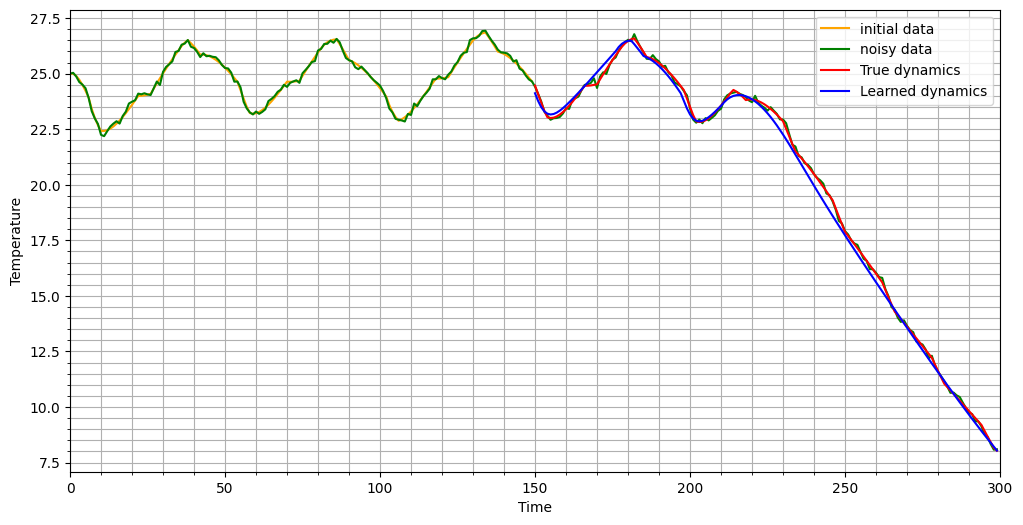

array([237.])

In [ ]:
#element to visualise
n=0
t=t_dr[+n]
noisy_t=noisy_t_dr[+n]
t_test=t_t[n]
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(12)
fig.set_figheight(6)
axs.plot(range(150), t[:150],'orange',label='initial data')
axs.plot(range(session_length), noisy_t,'green',label='noisy data')
axs.plot(range(150,session_length), t[150:],'red',label="True dynamics")
axs.plot(range(150,session_length),t_test, 'blue',label="Learned dynamics")
axs.set_xlim(0, session_length)
axs.set_xlabel('Time')
axs.set_ylabel('Temperature')
axs.grid(True)
axs.grid(which = "minor")
axs.minorticks_on()
axs.legend()
plt.show()
index[n]

# Fault test  

## individual test

In [ ]:
n=5
t=t_f[+n]
noisy_t=noisy_t_f[+n]
a_dec=a_f[+n]
t_out=t_out_f[+n]
a_faulty=a_fault[+n]

t_hist = t[:150].reshape((1, -1))
a_hist = a_dec[:150].reshape((1, -1))
t_out_hist = t_out[:150].reshape((1, -1))

'''future data, we are going to predict'''
t_future = t[150:]
a_future = a_dec[150:]
t_out_future = t_out[150:]

'''current temperature of prediction'''
s = np.array(t[150])

'''extraction of hidden GRU state using historical data'''
in_rnn_state = extract_hidden_state( t_hist, a_hist, t_out_hist)
print(t_out[0])
'''prediction loop'''

'''initializing t collection'''
t_test = []
for i in range(session_length-150):

    '''update temperature (s) and hidden GRU state'''
    s, in_rnn_state = dyn_predict(s, a_future[i], t_out_future[i], in_rnn_state)


    '''adding to t collection'''
    t_test.append(s)

t_test = np.array(t_test).flatten()
'''plotting of example'''
fig, axs = plt.subplots(2, 1,gridspec_kw={'height_ratios': [2, 1]})
fig.set_figwidth(8)
fig.set_figheight(6)
axs[0].plot(range(150), t[:150],'orange',label='Initial data')
axs[0].plot(range(session_length), noisy_t,'green',label='Noisy data')
axs[0].plot(range(150,session_length), t[150:],'red',label="True dynamics")
axs[0].plot(range(150,session_length),t_test, 'blue',label="Learned dynamics")
axs[0].set_xlim(0, session_length)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].grid(which = "minor")
axs[0].minorticks_on()
axs[0].legend()
axs[1].plot(a_dec, 'r',label="HVAC commands")
axs[1].plot(a_faulty, 'b',label="HVAC real commands")
#axs[1].plot(ac_c[n0], 'g',label="ac on/off comands")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Actions')
axs[1].grid(True)
axs[1].legend()
axs[1].grid(which = "minor")
axs[1].minorticks_on()
fig.tight_layout()



plt.show()
fig.savefig('filename.eps', format='eps')

NameError: name 'extract_hidden_state' is not defined

## batch test

In [ ]:

t_t =np.array(test_batch_fault( t_c_test, a_c_test, t_out_c_test,size=500))
np.savez_compressed("/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_fault_pred.npz",t_t=t_t )

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
number_of_pieces = 1
session_length = 300

num=2
level="low"
dir="/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_fault_"+str(num)+"_"+str(level)+"_noise.npz"
data_f= np.load(dir)
data_test= np.load("/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v7_test.npz")



t_out_f=np.vstack((data_f["t_out_f"],data_test["t_out_c"][:500]))
t_f=np.vstack((data_f["t_f"],data_test["t_c"][:500]))
noisy_t_f=np.vstack((data_f["noisy_t_f"],data_test["noisy_t_c"][:500]))
a_f=np.vstack((data_f["a_f"],data_test["a_c"][:500]))
a_fault=np.vstack((data_f['a_fault'],data_test["a_c"][:500]))

dir="/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_fault_"+str(num)+"_"+str(level)+"_noise_pred.npz"
data= np.load(dir)

data_t= np.load("/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_fault_pred.npz")
t_t=np.vstack((data["t_t"],data_t["t_t"]))

In [ ]:
t_out_f

array([[-14.95      , -14.95156737, -14.94457762, ..., -13.54437361,
        -13.54276269, -13.53697612],
       [-12.25      , -12.24646992, -12.24725246, ..., -10.99264071,
        -10.99475914, -10.99285677],
       [ -9.45      ,  -9.44957886,  -9.44163362, ...,  -8.05639774,
         -8.0534877 ,  -8.05058769],
       ...,
       [-11.01389771, -11.01027067, -11.01404372, ..., -10.90783524,
        -10.90637144, -10.9092483 ],
       [-10.91024445, -10.91619343, -10.92099204, ..., -12.48921929,
        -12.4958017 , -12.50109146],
       [-12.50467537, -12.5124511 , -12.51699857, ..., -14.36594134,
        -14.36075973, -14.35502808]])

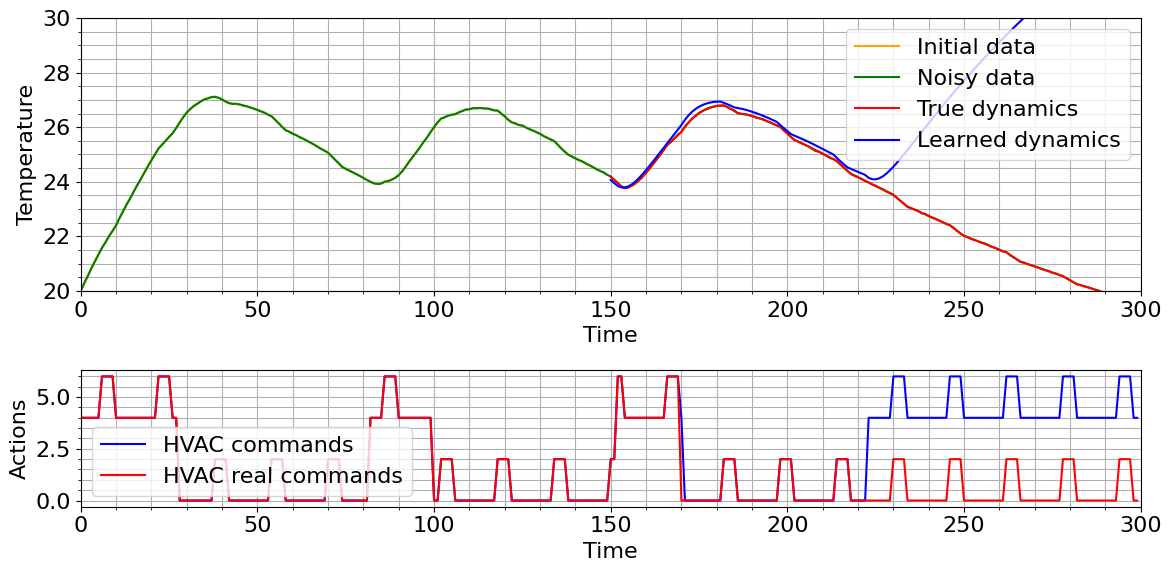

In [ ]:
n=10
t=t_f[+n]
t_pred=t_t[+n]
noisy_t=noisy_t_f[+n]
a_dec=a_f[+n]
t_out=t_out_f[+n]
a_faulty=a_fault[+n]
fig, axs = plt.subplots(2, 1,gridspec_kw={'height_ratios': [2, 1]})
fig.set_figwidth(12)
fig.set_figheight(6)
axs[0].plot(range(150), t[:150],'orange',label='Initial data')
axs[0].plot(range(session_length), noisy_t,'green',label='Noisy data')
axs[0].plot(range(150,session_length), t[150:],'red',label="True dynamics")
axs[0].plot(range(150,session_length),t_pred, 'blue',label="Learned dynamics")
#axs[0].axvspan(150+deviation[n],150+detection[n],color = 'b', label = 'Detection span '+str(detection[n]-deviation[n])+'min',alpha=0.2)
axs[0].set_xlim(0, session_length)
axs[0].set_ylim(20, 30)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].grid(which = "minor")
axs[0].minorticks_on()
axs[0].legend(loc=0)
axs[1].plot(a_dec, 'b',label="HVAC commands")
axs[1].plot(a_faulty, 'r',label="HVAC real commands")
#axs[1].plot(ac_c[n0], 'g',label="ac on/off comands")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Actions')
axs[1].grid(True)
axs[1].legend()
axs[1].grid(which = "minor")
axs[1].minorticks_on()
fig.tight_layout()

In [ ]:

def find_first_differences(matrix, t_hat):
    # Ensure both matrix and t_hat have the same number of rows
    if matrix.shape[0] != t_hat.shape[0]:
        raise ValueError("The number of vectors in the matrix and t_hat must be the same.")

    num_vectors = matrix.shape[0]
    results = []

    for i in range(num_vectors):
        vector1 = matrix[i]
        vector2 = t_hat[i]

        # Create a boolean array where elements are different
        differences = vector1 != vector2

        # Find the index of the first difference
        first_diff_index = np.argmax(differences)  # np.argmax returns the first maximum index (True)

        # Check if there was a difference found
        if differences[first_diff_index]:
            results.append(first_diff_index-150)
        else:
            results.append(150)  # No difference found

    return np.array(results)
import numpy as np

def first_out_of_tolerance_index(matrix1, matrix2, tolerance=1e-6):
    """
    Compare two matrices and return the index of the first value in each row
    where the difference between matrix1 and matrix2 exceeds the given tolerance.

    Args:
        matrix1 (np.ndarray): The first matrix.
        matrix2 (np.ndarray): The second matrix.
        tolerance (float): The tolerance within which values are considered "equal".

    Returns:
        list: List of column indices for the first out-of-tolerance value in each row.
              If no value in a row exceeds the tolerance, it returns -1 for that row.
    """
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same dimensions.")

    # Calculate the absolute difference between the two matrices
    diff = np.abs(matrix1 - matrix2)

    # Find where the difference exceeds the tolerance
    mask = diff > tolerance

    # List to store the first out-of-tolerance index for each row
    first_out_of_tolerance = []

    # Iterate over rows to find the first column index where the tolerance is exceeded
    for row_mask in mask:
        col_idx = np.argmax(row_mask)  # Find the first 'True' value in the row mask
        if row_mask[col_idx]:  # Ensure that the column index corresponds to an out-of-tolerance value
            first_out_of_tolerance.append(col_idx)
        else:
            first_out_of_tolerance.append(-1)  # If no value in the row is out of tolerance

    return first_out_of_tolerance





In [ ]:
ref=[0.1,0.204,0.204*1.25,0.204*1.5,0.204*1.75,0.204*2,0.204*2.25,0.204*2.5,0.204*2.75,0.204*3,0.204*4]
#ref=[0,-0.1,-0.204,-0.204*1.25,-0.204*1.5,-0.204*1.75,-0.204*2,-0.204*2.25,-0.204*2.5,-0.204*2.75,-0.204*3,-0.204*4,-0.204*5,-0.204*6,-0.204*10,-0.204*15]
precision=[]
recall=[]
time=[]
for i in ref:
  detection,deviation=fault_response_time(t_f[:,150:], np.array(t_t), window_size=10, reference_value=i,rmse_threshold=ref[-1]*0.3 ,RMSE= True )
  deviation=find_first_differences(a_f,a_fault)
  gr_true=deviation!=150
  #gr_true[:500]=1
  #gr_true[:500]=gr_true[:500]*pred[:500]
  pred=detection!=150
  time_i=detection- deviation
  time_i=time_i[time_i>0]
  time.append(time_i.mean())
  precision.append(precision_score(gr_true,pred))
  recall.append( recall_score(gr_true,pred))


In [ ]:
time

[1.0,
 2.136904761904762,
 2.554913294797688,
 3.1853932584269664,
 3.5280898876404496,
 4.129213483146067,
 4.477528089887641,
 4.966292134831461,
 5.337078651685394,
 5.578651685393258,
 7.258426966292135]

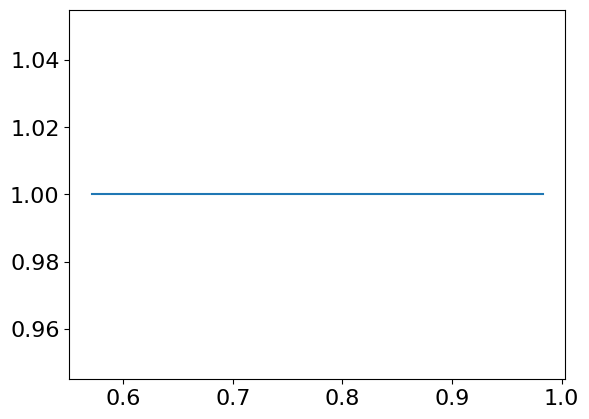

In [ ]:
plt.plot(precision,recall)


In [ ]:
precision

[0.19201725997842503,
 0.2176039119804401,
 0.24250681198910082,
 0.2692889561270802,
 0.29276315789473684,
 0.332089552238806,
 0.37872340425531914,
 0.4746666666666667,
 0.577922077922078,
 0.6926070038910506,
 0.9672131147540983]

In [ ]:
recall

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9943820224719101]